In [2]:
# packages
import numpy as np
import pandas as pd
import random
import os

# database
import yfinance as yf
from sqlalchemy import create_engine, inspect

# quadratic
import quadprog
from scipy.optimize import minimize

# visualisation
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from tabulate import tabulate


# maybe
import plotly.express as px
import matplotlib
from matplotlib.patches import Patch
plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('fivethirtyeight')
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm


/Users/jackstevenson/CQF/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


#### Data & Pre-Processing

In [3]:
# create our engine
engine = create_engine("sqlite:///project_portfolio.db")

df = pd.read_sql('portfolio_data', con=engine)

# # set date as index
df.set_index('Date', inplace=True)

# create separate t bill dataframe
three_month_tbill = df['3M TB'] / 252

# create separate benchmark dataframe
benchmark_spx_500 = df['Benchmark - S&P 500'].pct_change()

# consistent ordering
df = df[['Energy', 'Materials', 'Industrials', 'Consumer Discretionary', 'Consumer Staples', 'Health Care', 'Financials', 'Information Technology', 
         'Communication Services', 'Utilities', 'Real Estate', 'Volatility (Exo)', 'Commodities (Exo)', 'Bonds (Exo)', 'Factor SMB', 'Factor HML', 
         'Factor RMW', 'Factor CMA']]

# calculate simple returns
simple_returns = df.drop(columns=['Factor SMB', 'Factor HML', 'Factor RMW', 'Factor CMA']).pct_change()

simple_returns = pd.concat([simple_returns, df[['Factor SMB', 'Factor HML', 'Factor RMW', 'Factor CMA']]], axis=1)

/var/folders/3z/lz8knlfn5ys693qpn6bnjb440000gn/T/ipykernel_36456/3435988170.py:21: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  simple_returns = df.drop(columns=['Factor SMB', 'Factor HML', 'Factor RMW', 'Factor CMA']).pct_change()


#### Custom Factor - Momentum Factor

In [4]:
# lookback period 252 (approximate 12 months)
lookback_period = 252

# exclude the exogenous and fama-french
sector_momentum = simple_returns.drop(columns=['Volatility (Exo)', 'Commodities (Exo)', 
                                               'Bonds (Exo)','Factor SMB', 'Factor HML', 
                                               'Factor RMW', 'Factor CMA']).rolling(window=lookback_period).apply(lambda x: (x + 1).prod() - 1)

# rank the sector returns over lookback plus lag to prevent perfect portfolio
momentum_ranks = sector_momentum.rank(axis=1, method='first', ascending=False).shift(1).dropna()

# identify top and bottom
top_momentum_sectors = momentum_ranks <= 3  # Top 3 sectors
bottom_momentum_sectors = momentum_ranks >= 9  # Bottom 3 sectors

# construct portfolio returns from top & bottom
momentum_high_portfolio = simple_returns[top_momentum_sectors].mean(axis=1)
momentum_low_portfolio = simple_returns[bottom_momentum_sectors].mean(axis=1)

# calculate momentum factor returns
momentum_factor_return = momentum_high_portfolio - momentum_low_portfolio
momentum_factor_return_df = momentum_factor_return.to_frame(name='Factor MOM')

# add into simple_returns_df
simple_returns = pd.concat([simple_returns, momentum_factor_return_df], axis=1)

# drop the first 12 months due to lookback
simple_returns.dropna(inplace=True)

#### Create Excess and Log Returns

In [5]:
# subtract the 3m t bill daily rate
excess_returns = simple_returns.sub(three_month_tbill, axis=0)

# calculate log returns returns
log_returns = np.log(1 + simple_returns).dropna()

#### Figure 1 - Data Sources

In [6]:
sectors_and_data_source = pd.Series({
    'Energy': 'iShares U.S. Energy ETF (IYE)',
    'Materials': 'iShares U.S. Materials ETF (IYM)',
    'Industrials': 'iShares U.S. Industrials ETF (IYJ)',
    'Consumer Discretionary': 'iShares U.S. Consumer Disc ETF (IYC)',
    'Consumer Staples': 'iShares U.S. Consumer Staples ETF (IYK)',
    'Health Care': 'iShares U.S. Healthcare ETF (IYH)',
    'Financials': 'iShares U.S. Financials ETF (IYF)',
    'Information Technology': 'iShares U.S. Technology ETF (IYW)',
    'Communication Services': 'iShares U.S. Telecom ETF (IYZ)',
    'Utilities': 'iShares U.S. Utilities ETF (IDU)',
    'Real Estate': 'iShares US Real Estate ETF (IYR)',
    'Volatility (Exo)': 'CBOE Volatility Index (VIX)',
    'Commodities (Exo)': 'Bloomberg Commodity Index Total Return (BCOM)',
    'Bonds (Exo)': 'iShares Core US Aggregate Bond ETF (AGG)',
    'Factor SMB': 'Fama-French - Small Minus Big',
    'Factor HML': 'Fama-French - High Minus Low',
    'Factor RMW': 'Fama-French - Robust Minus Weak',
    'Factor CMA': 'Fama-French - Conservative Minus Aggressive',
    'Factor MOM': 'Custom - Momentum High Minus Low',
    })

data_source_df = pd.DataFrame(sectors_and_data_source, columns=['Data Source'])

data_source_df.index.name = 'Porfolio Factors'

# print(tabulate(data_source_df, headers='keys', tablefmt='pipe'))

In [7]:
# Step 1: Find the common date index (intersection of both indexes)
common_index = log_returns.index.intersection(benchmark_spx_500.index)

# split the index between backtesting and post optimisation periods
backtesting_index = common_index[common_index < '2022-01-01']
post_optimisation_index = common_index[common_index >= '2022-01-01']

# Step 2: Filter both DataFrames to only include the common dates
log_returns_back_testing = log_returns.loc[backtesting_index]
benchmark_spx_500_back_testing = benchmark_spx_500.loc[backtesting_index]

#### Figure 1 - Portfolio Factor Correlation Matrix

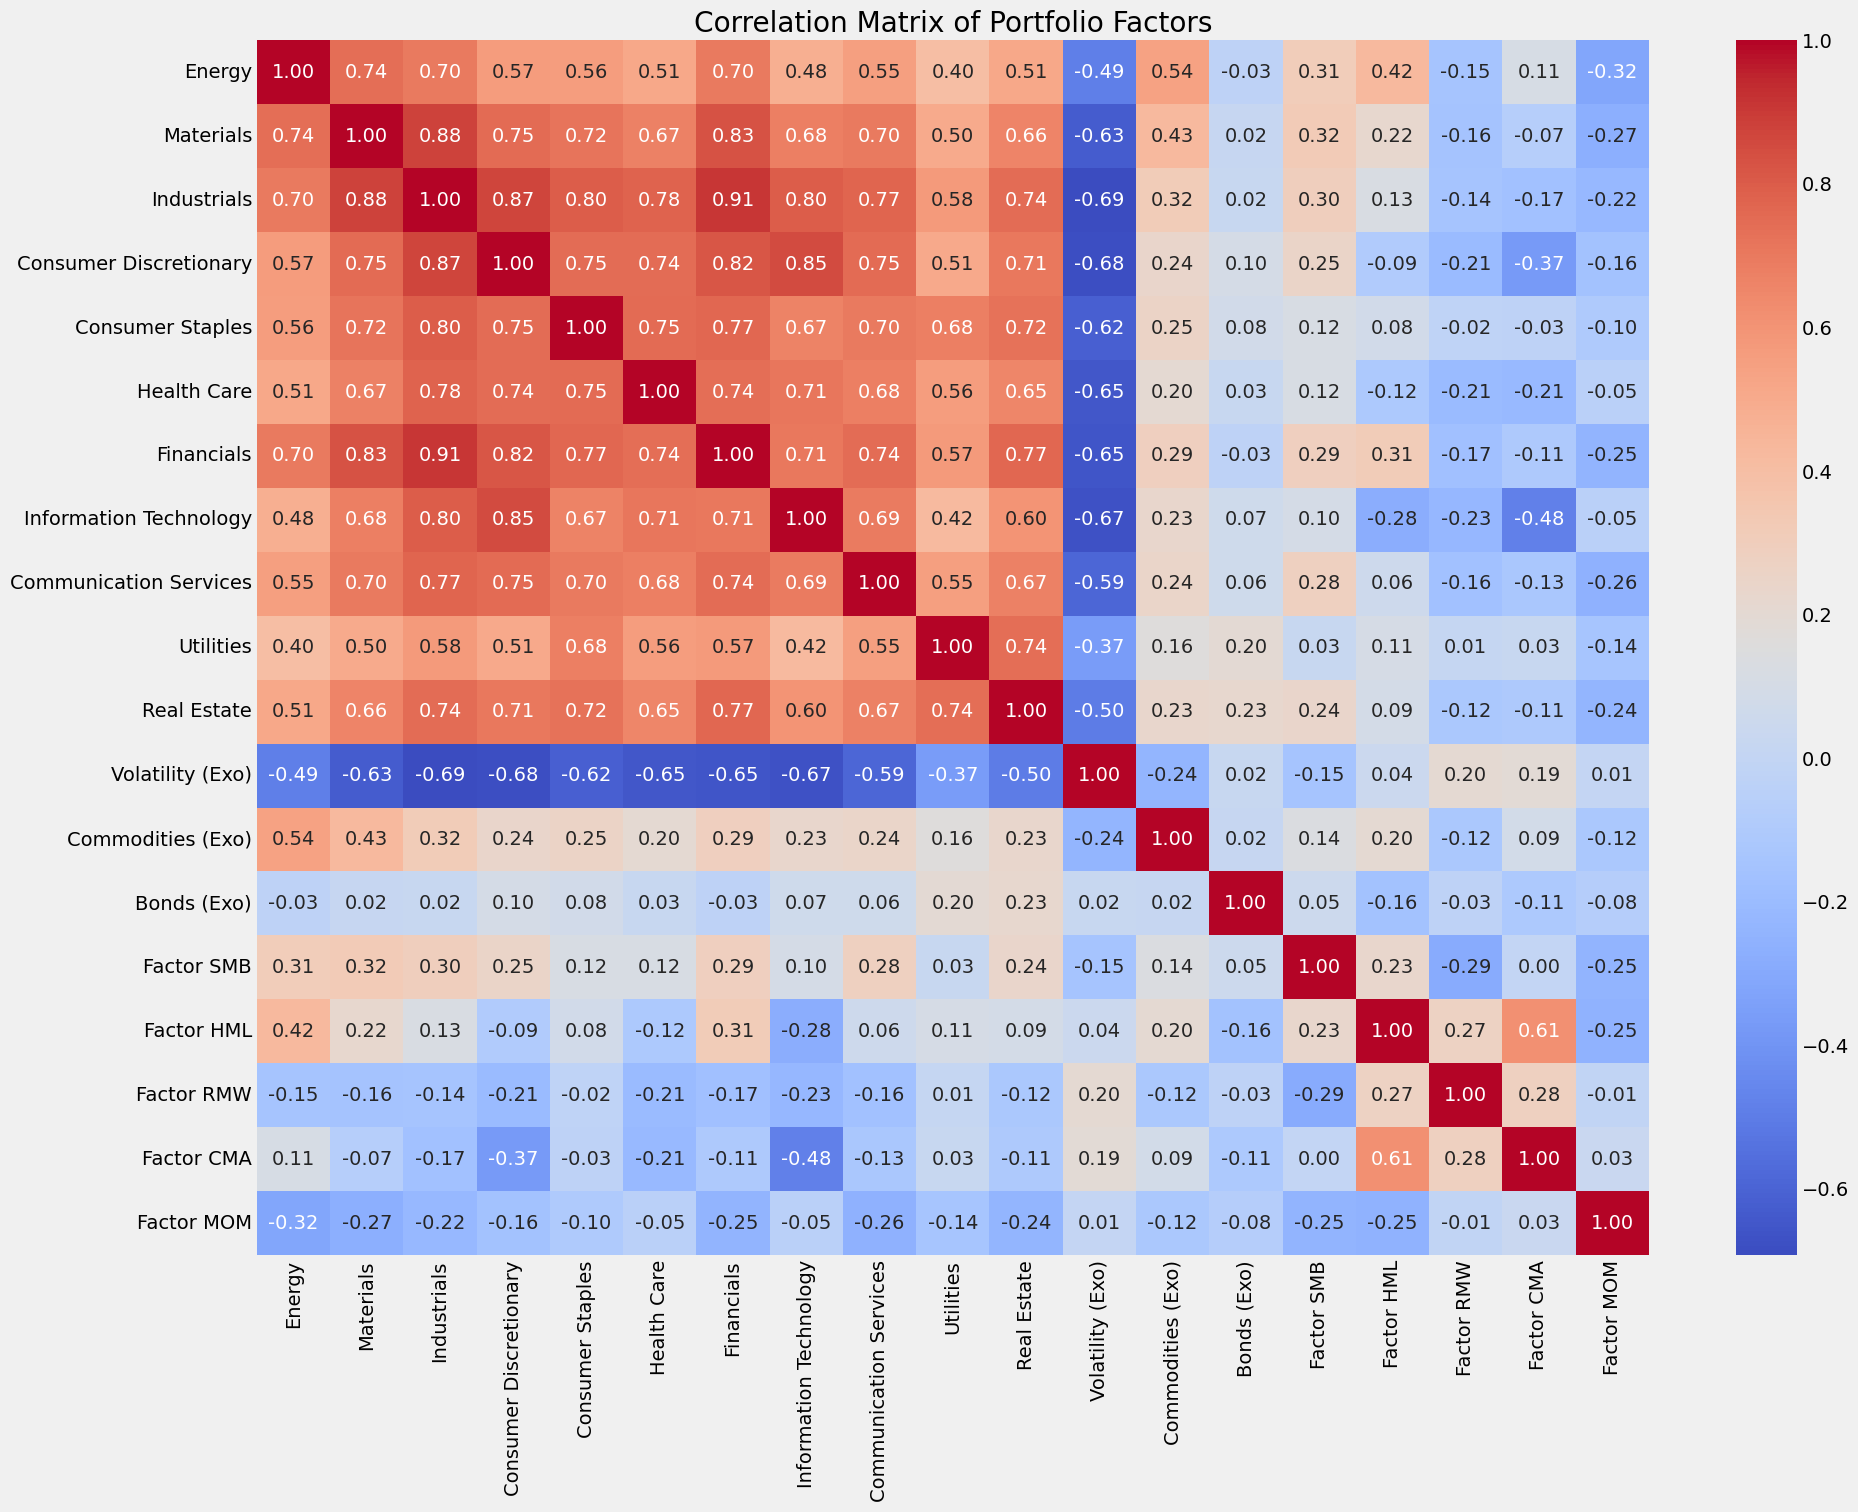

In [8]:
correlation_matrix = log_returns.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Correlation Matrix of Portfolio Factors')
plt.show()

#### Figure 2 - Rolling Beta vs Benchmark

In [9]:
# calculate rolling beta function
def calculate_rolling_beta(factor_returns, market_returns, window):
    return factor_returns.rolling(window=window).apply(
        lambda z: np.cov(z, market_returns.loc[z.index].squeeze())[0, 1] / np.var(market_returns.loc[z.index].squeeze()),
        raw=False
    )

In [10]:
# window over 1 year
window = 252

# number of factors 
num_factors = len(log_returns_back_testing.columns)

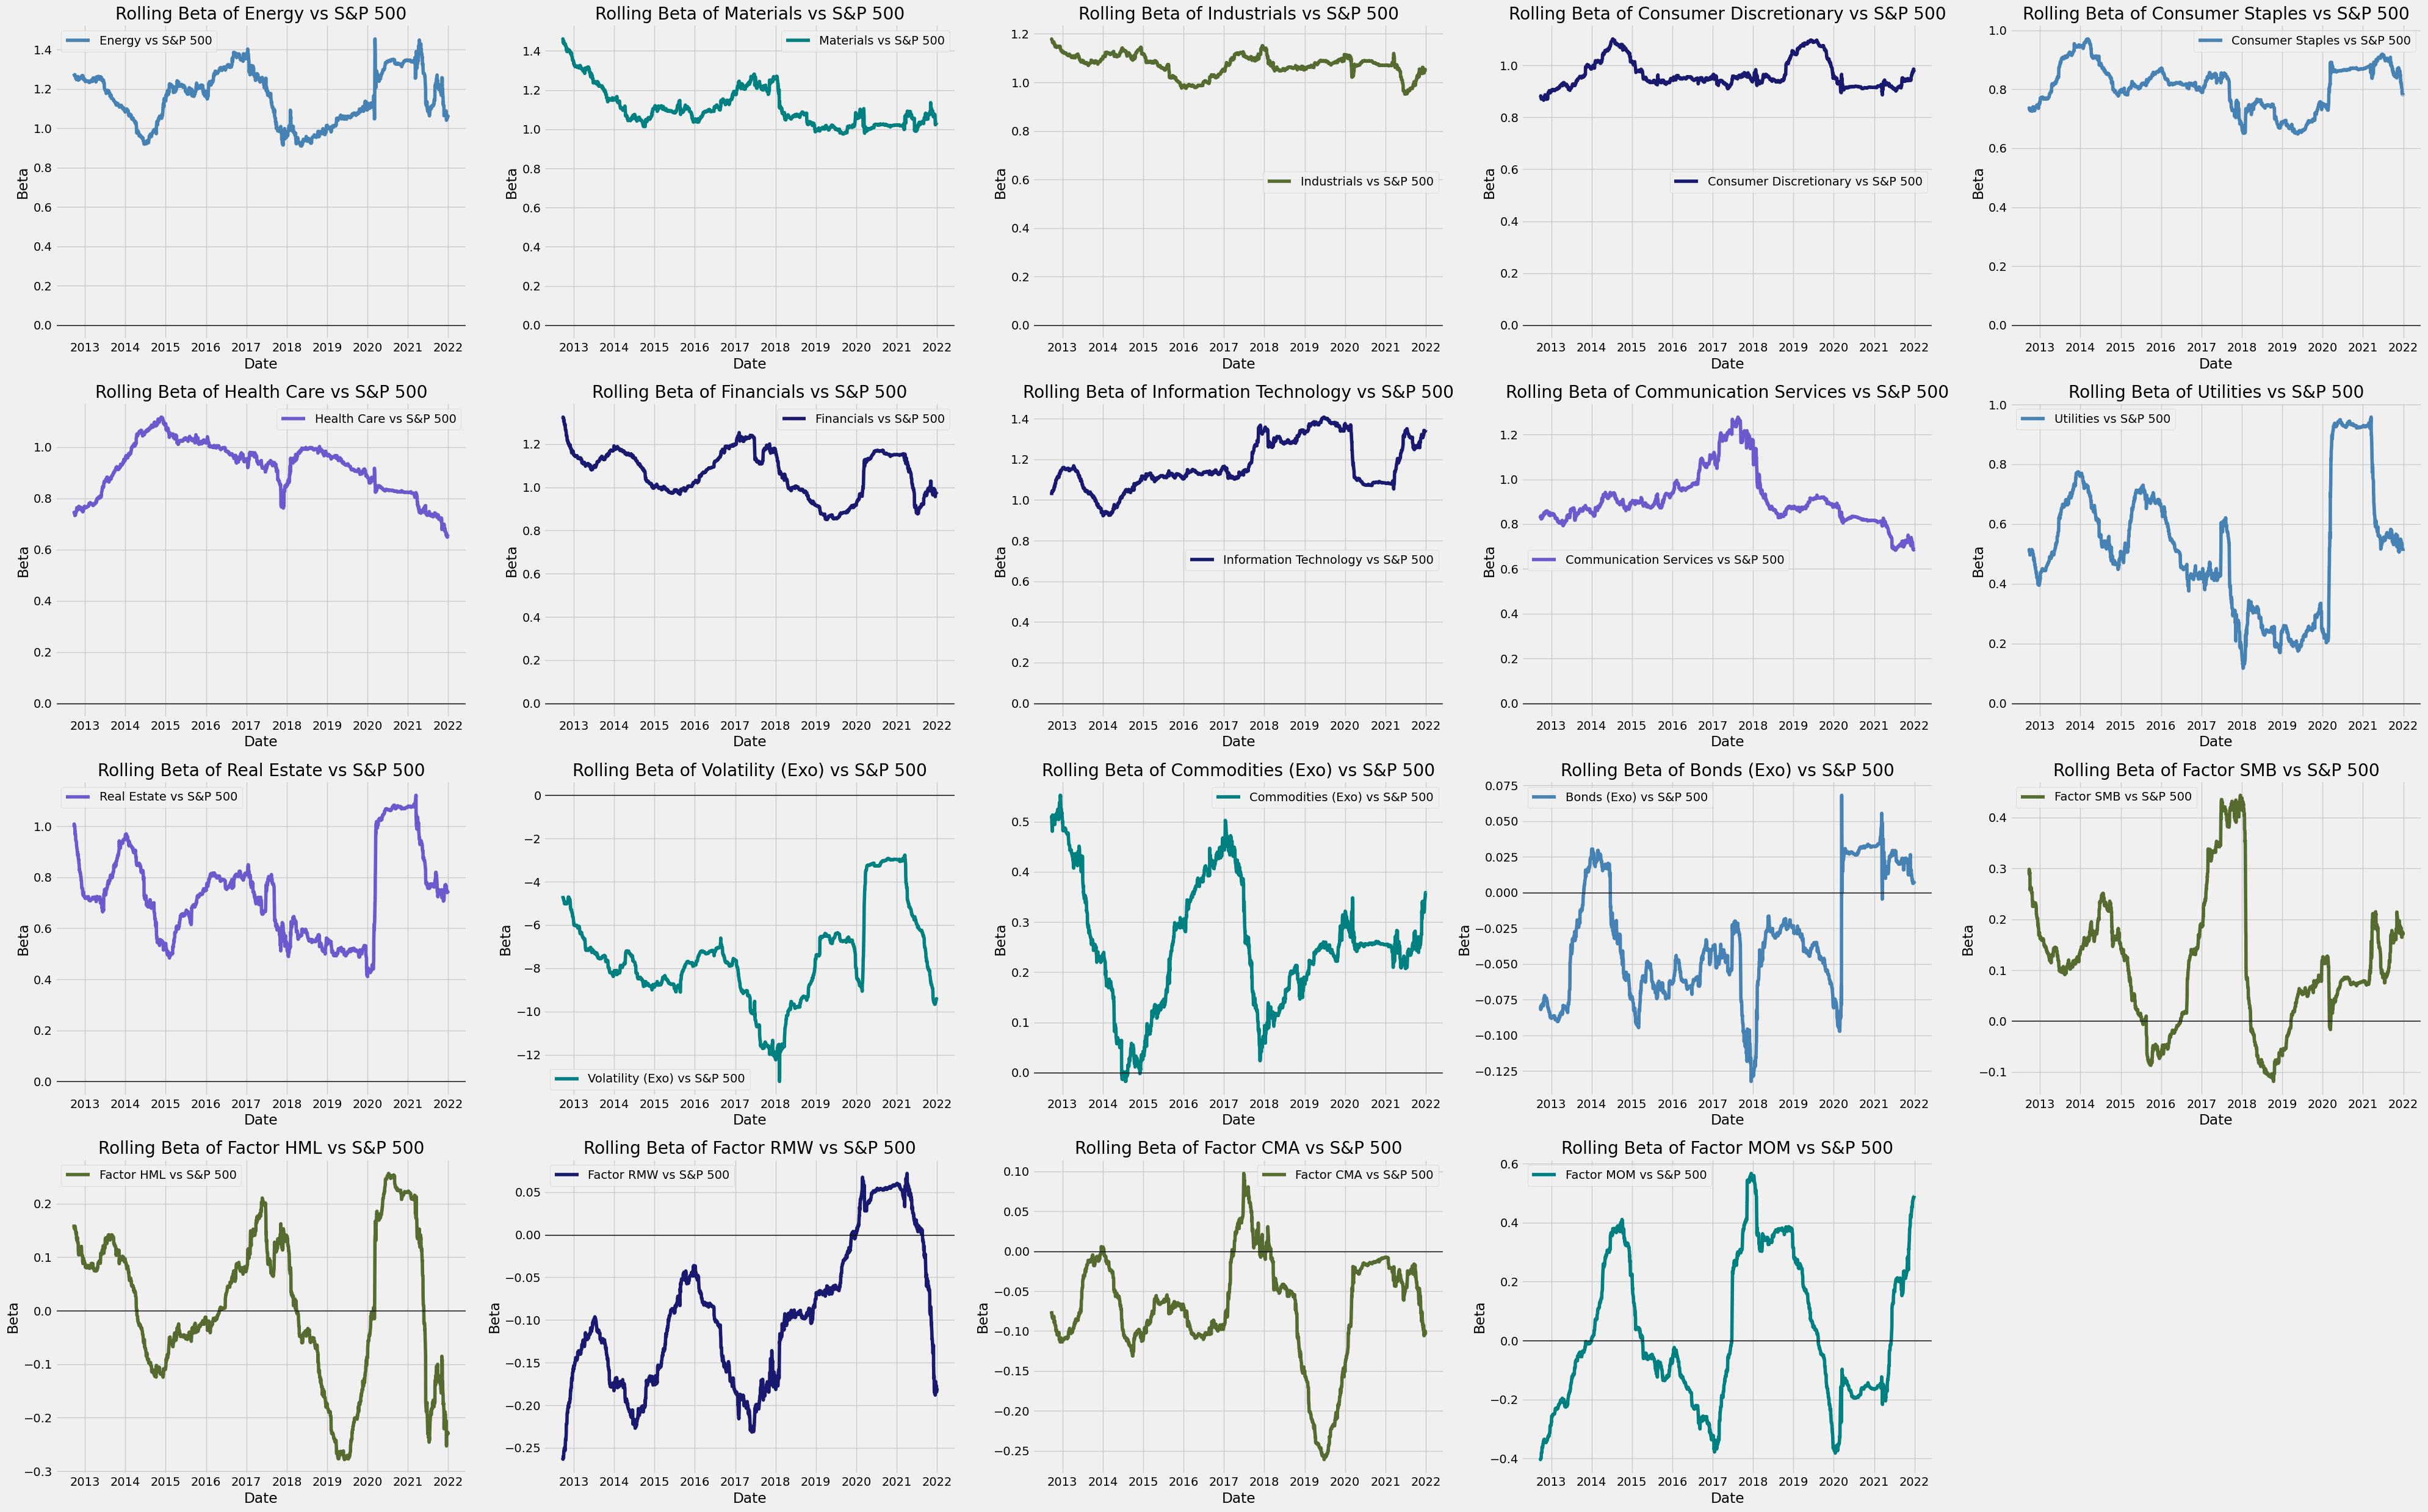

In [11]:
# grid layout
nrows = 4
ncols = 5

# subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(40, 25))
axes = axes.flatten()

# colour palette
colours = ['#6a5acd', '#008080', '#4682b4', '#556b2f', '#191970']
colours *= (len(log_returns_back_testing.columns) // len(colours)) + 1
random.shuffle(colours)

for i, column in enumerate(log_returns_back_testing.columns):
    rolling_beta = calculate_rolling_beta(log_returns_back_testing[column], benchmark_spx_500_back_testing.squeeze(), window)
    axes[i].plot(rolling_beta.index, rolling_beta, label=f'{column} vs S&P 500', color=colours[i % len(colours)])
    axes[i].axhline(0, color='black', linewidth=1)
    axes[i].set_title(f'Rolling Beta of {column} vs S&P 500')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Beta')
    axes[i].legend()
    axes[i].grid(True)

# Hide the last empty subplot if necessary
if len(log_returns_back_testing.columns) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

#### Figure 4 - Rolling Alpha vs Benchmark

In [12]:
# calculate rolling alpha
def calculate_rolling_alpha(factor_returns, market_returns, window):
    return factor_returns.rolling(window=window).apply(
        lambda z: np.polyfit(market_returns.loc[z.index].squeeze(), z, 1)[1],
        raw=False
    )

In [13]:
# window over 1 year
window = 252

# number of factors 
num_factors = len(log_returns_back_testing.columns)

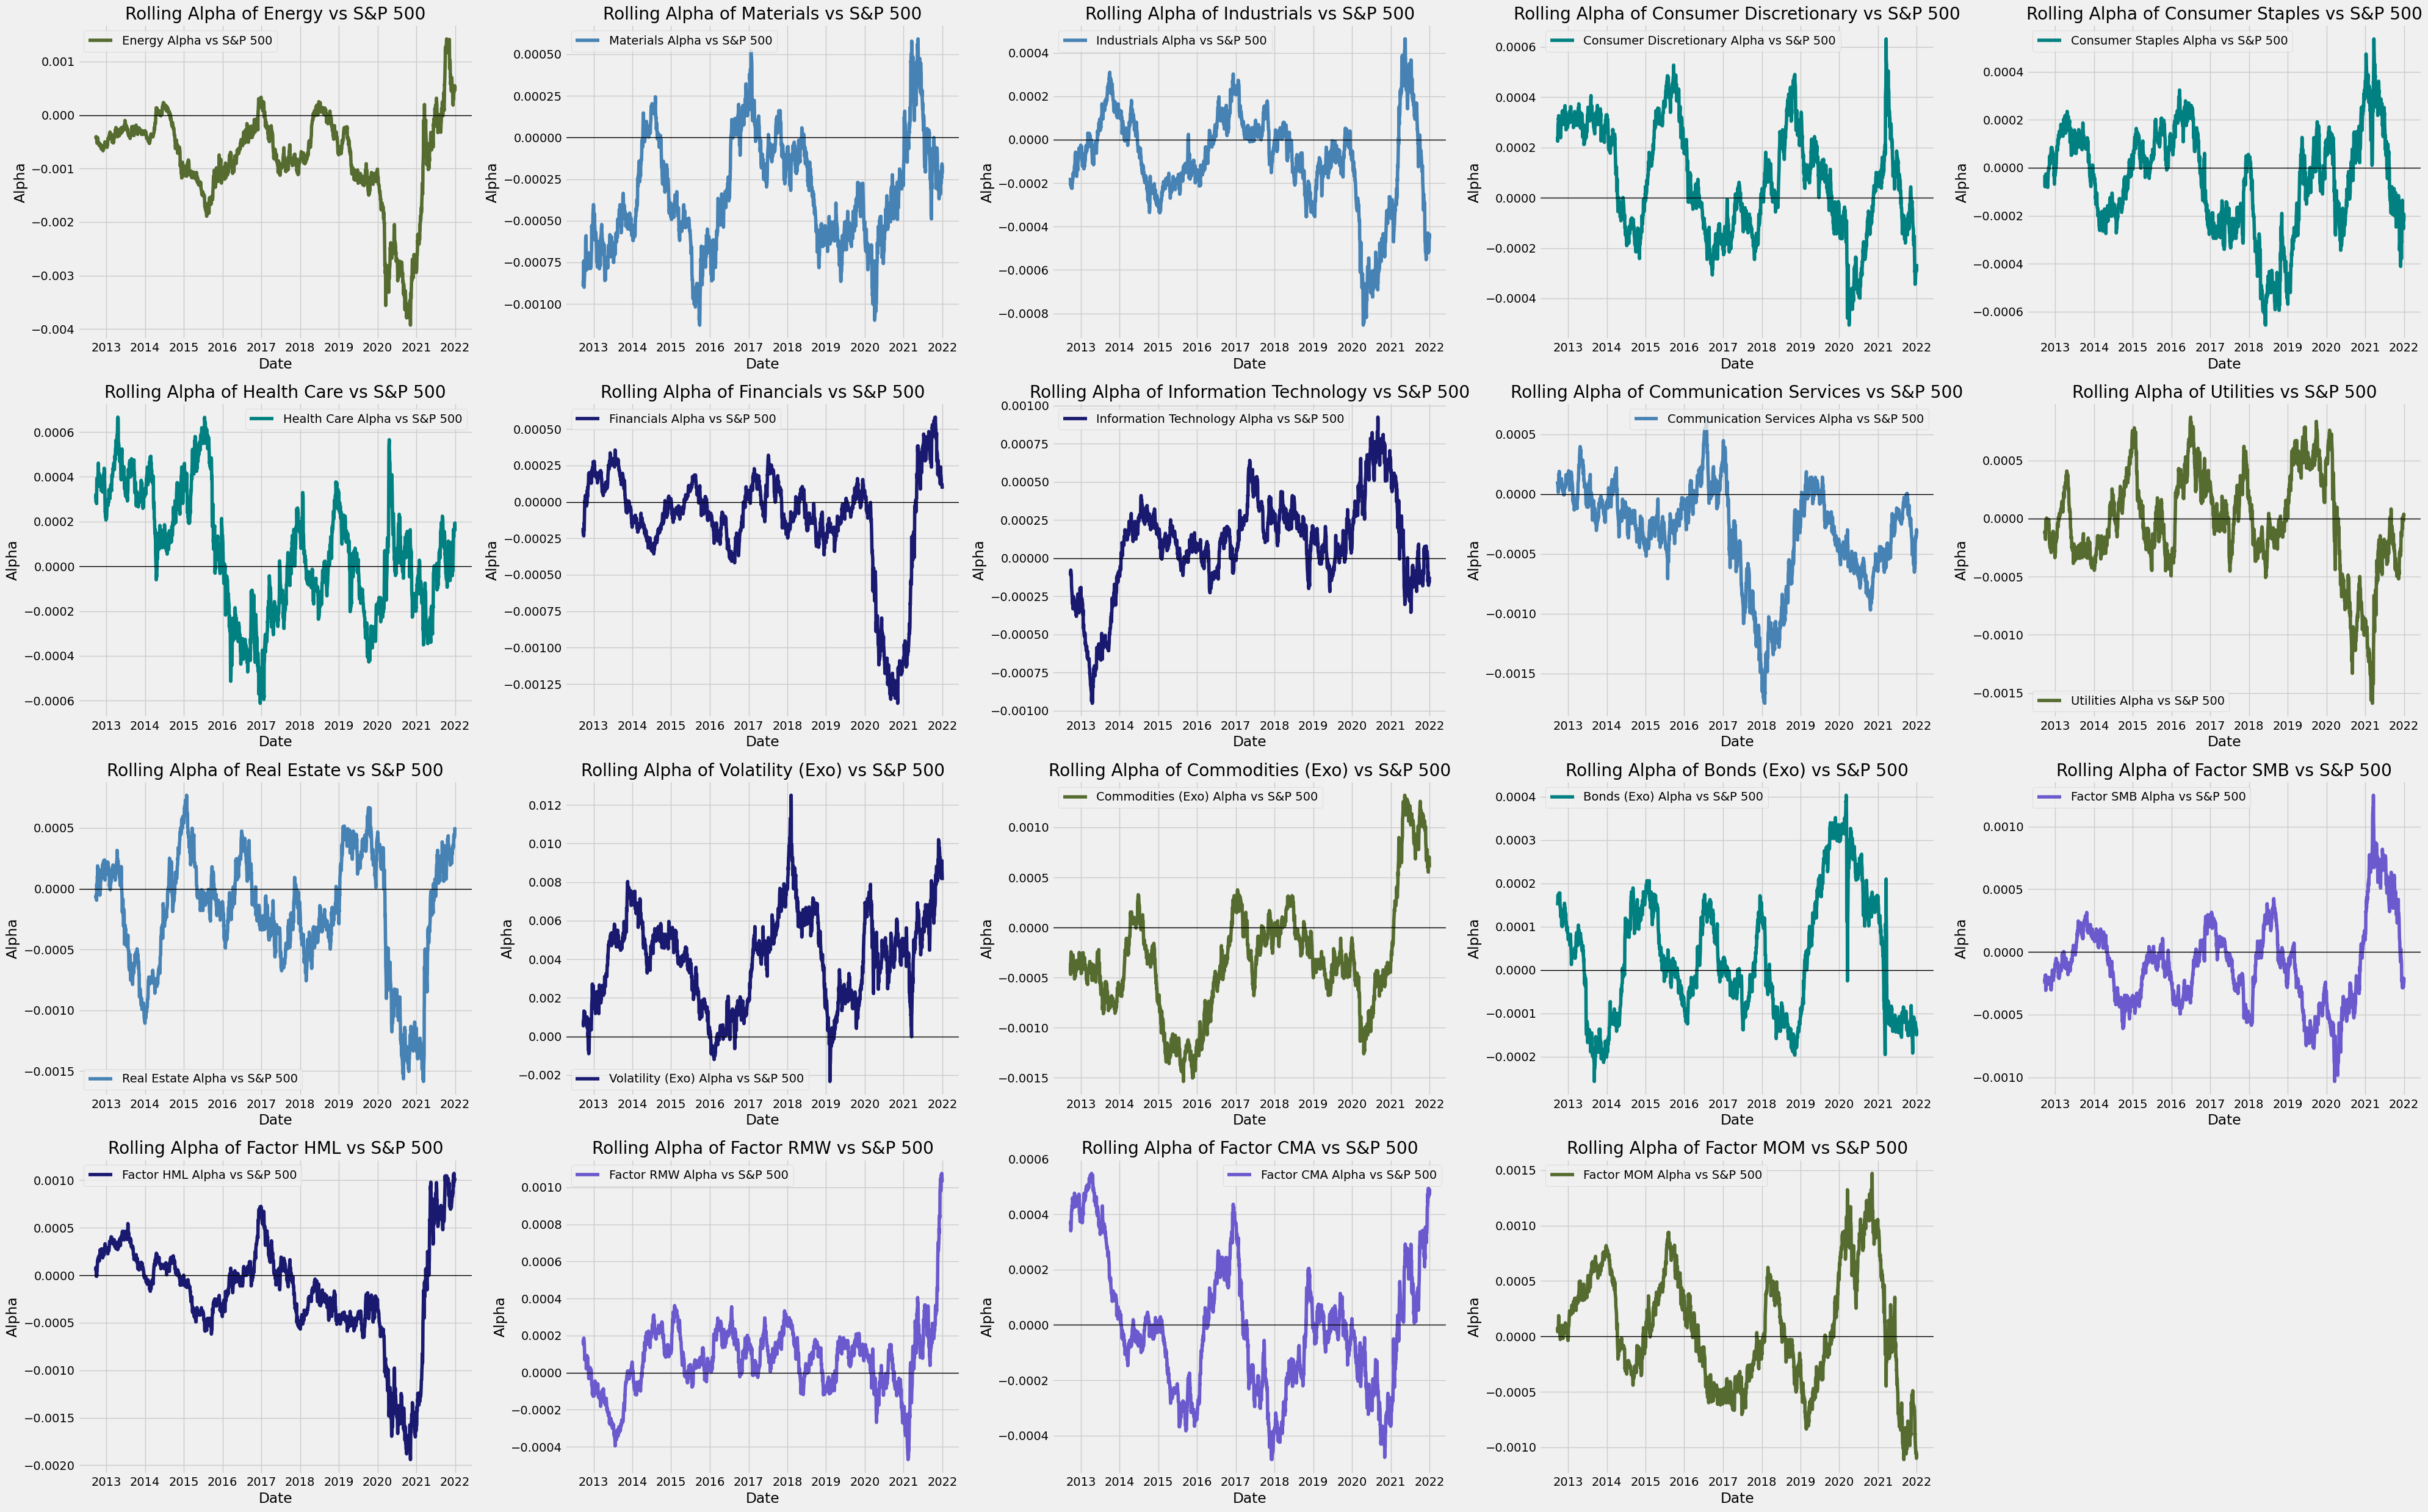

In [14]:
# Grid layout for subplots
nrows = 4
ncols = 5

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(40, 25))
axes = axes.flatten()

# Colour palette
colours = ['#6a5acd', '#008080', '#4682b4', '#556b2f', '#191970']
colours *= (len(log_returns_back_testing.columns) // len(colours)) + 1
random.shuffle(colours)

# Loop over each factor to compute and plot rolling alpha
for i, column in enumerate(log_returns_back_testing.columns):
    rolling_alpha = calculate_rolling_alpha(log_returns_back_testing[column], benchmark_spx_500_back_testing.squeeze(), window)
    axes[i].plot(rolling_alpha.index, rolling_alpha, label=f'{column} Alpha vs S&P 500', color=colours[i % len(colours)])
    axes[i].axhline(0, color='black', linewidth=1)
    axes[i].set_title(f'Rolling Alpha of {column} vs S&P 500')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Alpha')
    axes[i].legend()
    axes[i].grid(True)

# Hide the last empty subplot if necessary
if len(log_returns_back_testing.columns) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

#### Figure 4 - Portfolio Factor Performance vs Benchmark

In [15]:
simple_returns_back_testing = np.exp(log_returns_back_testing) - 1

# calculate cumulative returns
cumulative_returns_back_testing = (1 + simple_returns_back_testing).cumprod() - 1
cumulative_benchmark_spx_500_back_testing = (1 + benchmark_spx_500_back_testing).cumprod() - 1

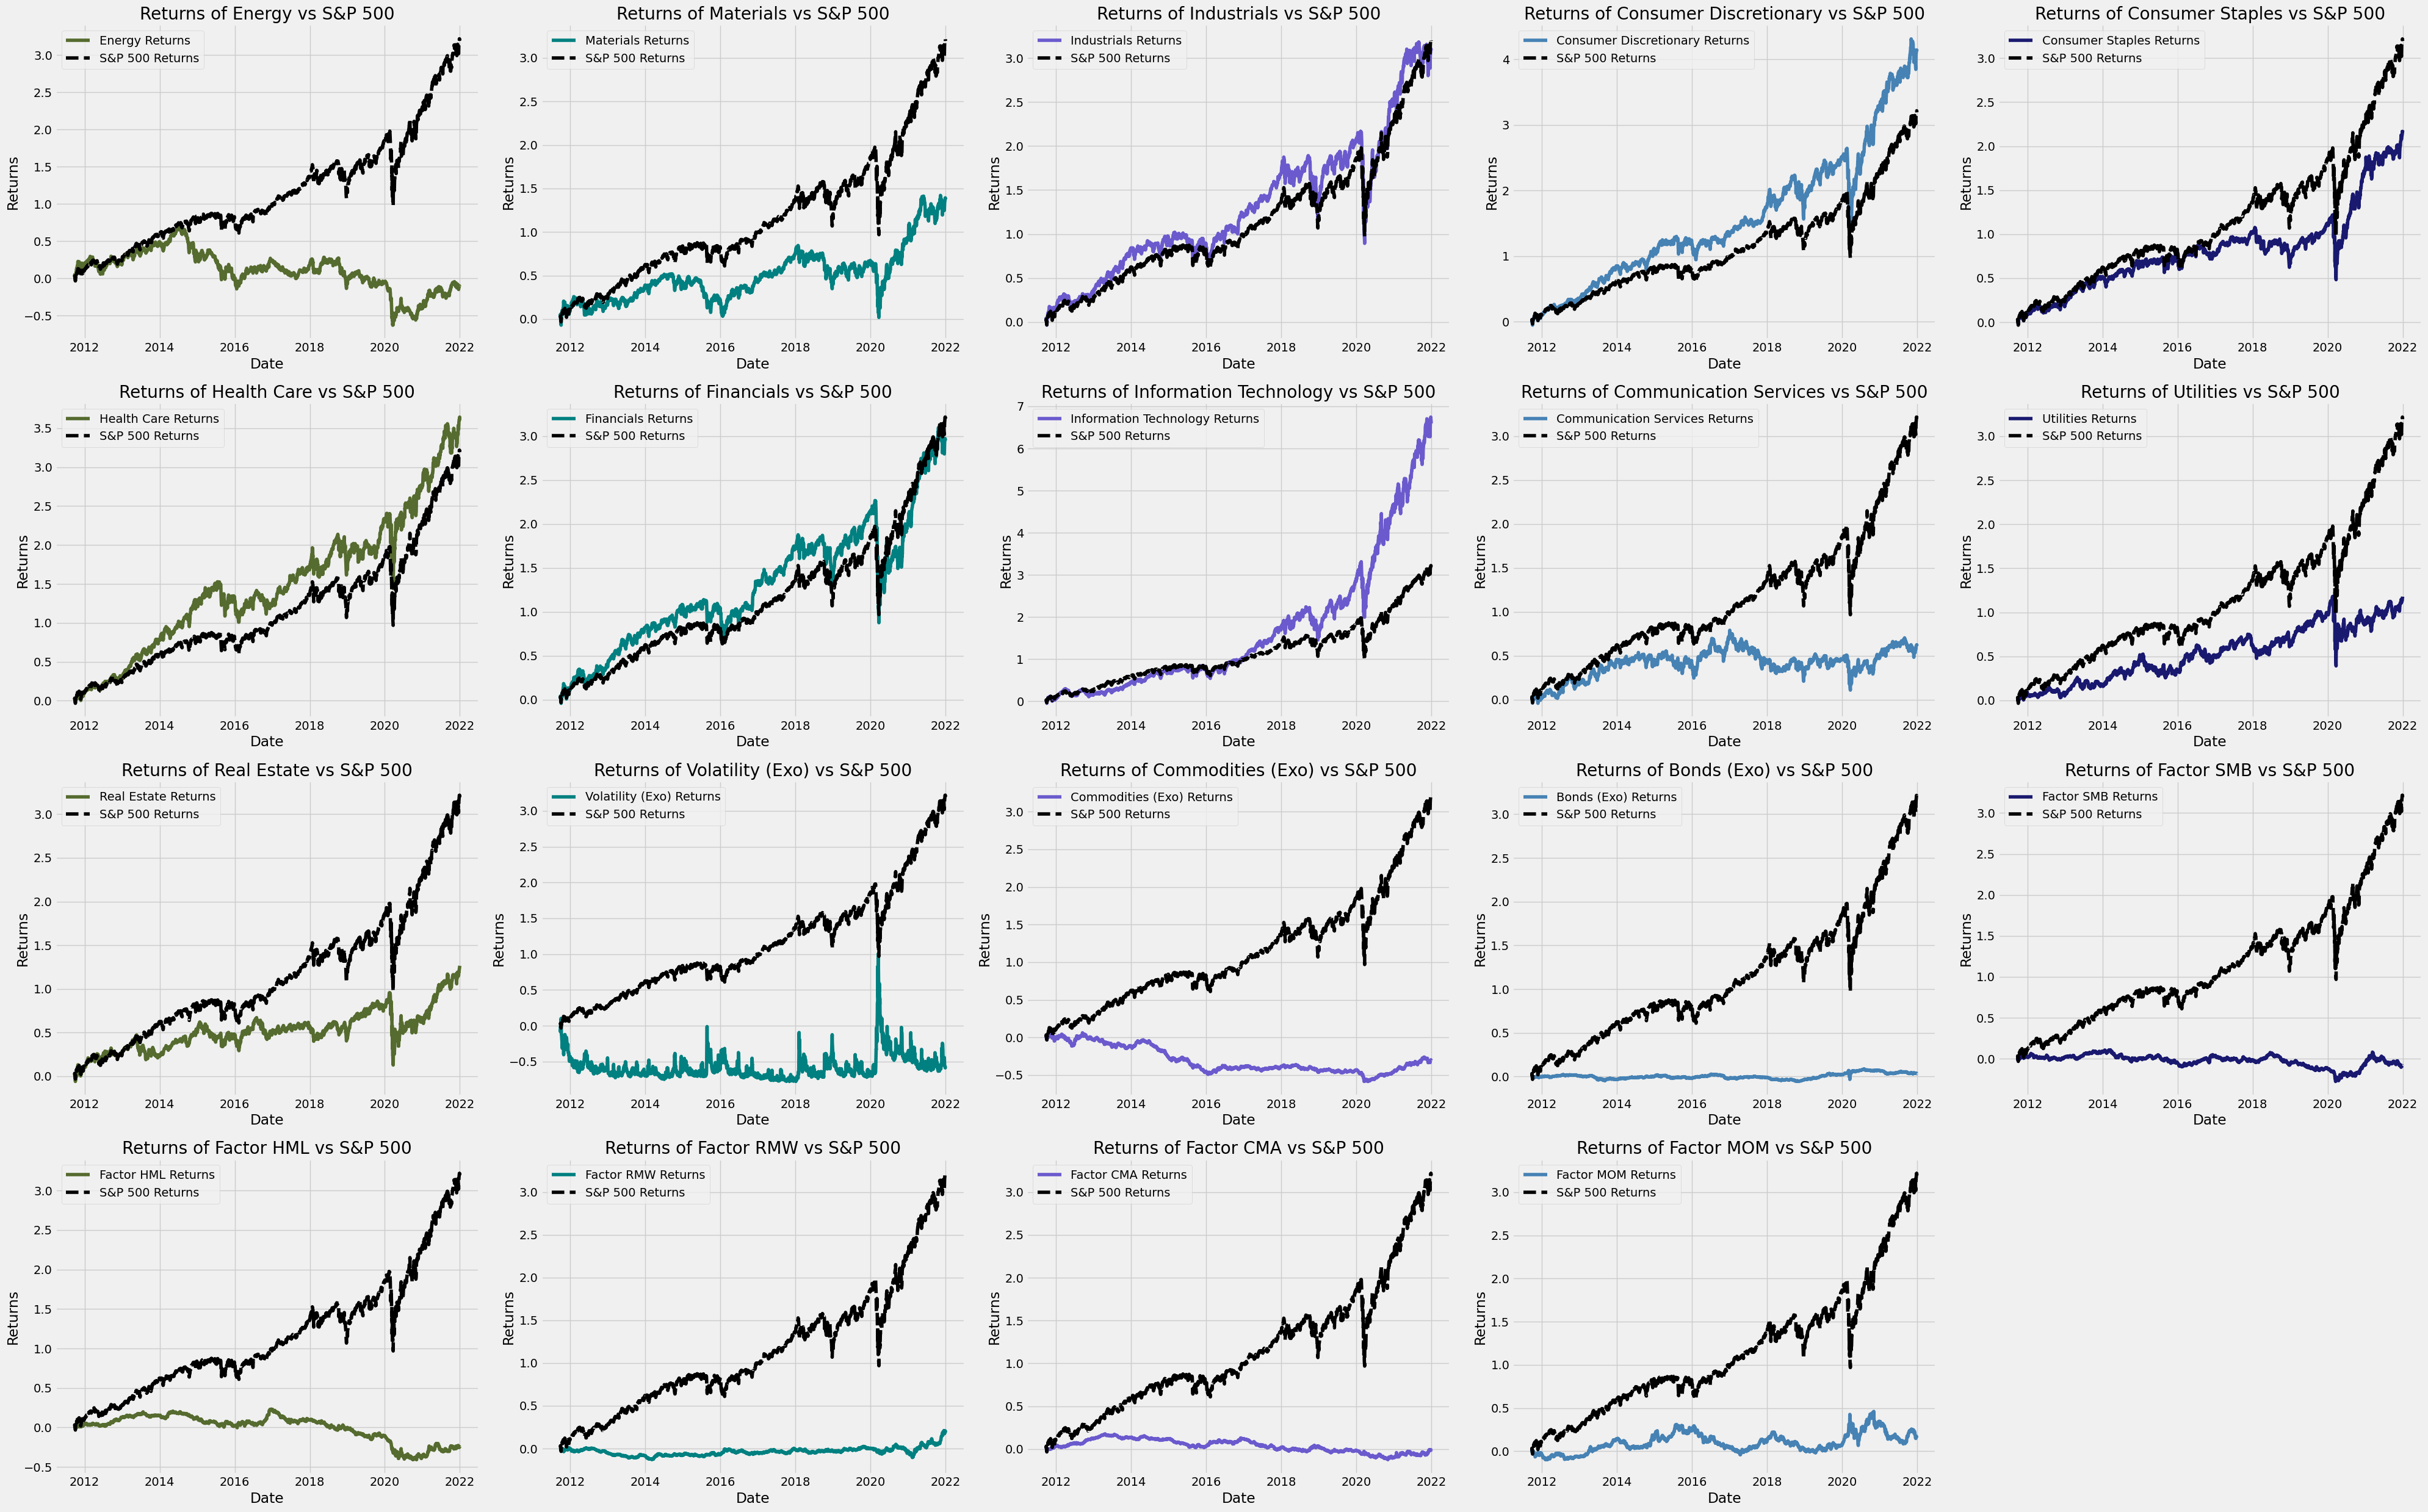

In [16]:
# dimensions of plot
nrows = 4
ncols = 5

# create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(40, 25))
axes = axes.flatten()

# colour palette
colours = ['#6a5acd', '#008080', '#4682b4', '#556b2f', '#191970']
random.shuffle(colours)

# plot factor returns vs benchmark
for i, column in enumerate(cumulative_returns_back_testing.columns):

    axes[i].plot(cumulative_returns_back_testing.index, cumulative_returns_back_testing[column], label=f'{column} Returns', color=colours[i % len(colours)])
    axes[i].plot(cumulative_benchmark_spx_500_back_testing.index, cumulative_benchmark_spx_500_back_testing, label='S&P 500 Returns', color='black', linestyle='--')
    axes[i].set_title(f'Returns of {column} vs S&P 500')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Returns')
    axes[i].legend()
    axes[i].grid(True)

# hide empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Black-Litterman Model

In [17]:
class BlackLittermanModel:
    def __init__(self, equilibrium_weights, log_returns, risk_aversion, views_mapping_matrix, views_matrix, tracking_error_target=0.00000009, tau=0.025):
        self._equilibrium_weights = equilibrium_weights
        self._log_returns = log_returns
        self._risk_aversion = risk_aversion
        self._tau = tau
        self._covariance_matrix = self._calculate_covariance_matrix()
        self._views_mapping_matrix = views_mapping_matrix
        self._views_matrix = views_matrix
        self._tracking_error_target = tracking_error_target 

    # TODO: private methods
    def _calculate_covariance_matrix(self):
        # calculate the vols
        volatilities_array = self._log_returns.std()

        # calculate correlation
        correlation_coefficients = self._log_returns.corr()

        # create the diagonal vol matrix (vol on the diagonal, zeros elsewhere)
        std_diag_vol_matrix  = np.diag(volatilities_array)

        # compute the covariance matrix
        covariance_matrix = std_diag_vol_matrix @ correlation_coefficients.values @ std_diag_vol_matrix

        # pass the headers from log return 

        covariance_matrix = pd.DataFrame(
            covariance_matrix,
            columns = self._log_returns.columns,
            index = self._log_returns.columns,
        )

        return covariance_matrix
    
    def calculate_views_adjusted_returns(self):
        # we need implied equity returns and omega
        implied_returns_vector = self.calculate_implied_equilibrium_returns().values

        omega = self.calculate_uncertainty_views_matrix()

        # we have three terms for the np.dot product
        tau_sigma_transpose_p = self._tau * (self._covariance_matrix.values @ self._views_mapping_matrix.T)

        inverse_middle_term = np.linalg.inv((self._views_mapping_matrix @ tau_sigma_transpose_p) + omega)

        view_minus_p = (self._views_matrix - (self._views_mapping_matrix @ implied_returns_vector))

        views_adjusted_returns_vector = implied_returns_vector + ((tau_sigma_transpose_p @ inverse_middle_term) @ view_minus_p)

        # convert to dataframe for consistency
        views_adjusted_returns = pd.DataFrame(views_adjusted_returns_vector, columns=["Adjusted Return"], index=self._log_returns.columns)

        return views_adjusted_returns
    
    # calculate the covariance of the error terms aka omega
    def calculate_uncertainty_views_matrix(self):
        # you extract the diagonal and then convert to a diagonal matrix with zeros
        omega = np.diag(((self._views_mapping_matrix @ (self._tau * self._covariance_matrix)) @ self._views_mapping_matrix.T))
        
        return np.diag(omega)

    
    def calculate_implied_equilibrium_returns(self):
        implied_returns_vector = self._risk_aversion * (self._covariance_matrix @ self._equilibrium_weights)

        implied_returns = pd.DataFrame(implied_returns_vector, columns=["Implied Return"], index=self._log_returns.columns)

        return implied_returns
    
    def calculate_unconstrained_mv_optimisation(self):
        # invert the covariance matrix
        inv_cov_matrix = np.linalg.inv(self._covariance_matrix)

        # calculate adjusted returns
        adjusted_returns = self.calculate_views_adjusted_returns().values

        # obtain weights
        optimal_weights = self._risk_aversion * np.dot(inv_cov_matrix, adjusted_returns)

        # # normalise the sum of weights to 1
        optimal_weights /= np.sum(optimal_weights)

        # convert to dataframe for consistency
        optimal_weights = pd.DataFrame(optimal_weights, columns=["Adjusted Weights"], index=self._log_returns.columns)

        return optimal_weights
    
    def generate_mv_constraint_matrices(self, implied_returns_vector_values):
        # we will generate our two constraints - no short selling & no leverage
        number_of_assets = len(implied_returns_vector_values)

        # no short selling
        no_short_selling_constraint_coefficient = np.eye(number_of_assets)
        no_short_selling_constraint_rhs = np.zeros(number_of_assets)

        # no leverage - you need to transpose the 
        no_leverage_constraint_coefficient = np.ones([1, number_of_assets])
        no_leverage_constraint_rhs = np.array([1.0])

        # stack them together
        C_constraint_matrix = np.vstack([no_leverage_constraint_coefficient, no_short_selling_constraint_coefficient])
        b_constraint_matrix = np.hstack([no_leverage_constraint_rhs, no_short_selling_constraint_rhs])

        return C_constraint_matrix, b_constraint_matrix
    
        
    def calculate_constrained_mv_optimisation(self):
        implied_returns_vector_values = self.calculate_implied_equilibrium_returns().values

        # we are solving an equation of the form - 1/2 x^T G x - a^T x s.t. C.T x >= b
        quadratic_G = self.risk_aversion * self._covariance_matrix.values

        quadratic_a = self.calculate_views_adjusted_returns().values.flatten()

        # generate constraints
        C_constraint_matrix, b_constraint_matrix = self.generate_mv_constraint_matrices(implied_returns_vector_values)

        # solve for weights
        optimal_weights = quadprog.solve_qp(quadratic_G, quadratic_a, C_constraint_matrix.T, b_constraint_matrix, meq=1)[0]

        optimal_weights = pd.DataFrame(optimal_weights, columns=["Constrained Adjusted Weights"], index=self._log_returns.columns)

        return optimal_weights
    
    
    def calculate_tracking_error_optimisation(self):
        implied_returns_vector_values = self.calculate_implied_equilibrium_returns().values

        number_of_assets = len(implied_returns_vector_values)

        adjusted_returns = self.calculate_views_adjusted_returns().values

        # constraints
        constraints = [{'type': 'eq', 'fun': self.zero_sum_equality_constraint},
                       {'type': 'eq', 'fun': self.tracking_error_target_constraint}]
        

        # bounds - no short selling or other constraints
        bounds = [(None, None)] * number_of_assets

        # initial guess - very small non-zero deviation
        x0 = np.ones(number_of_assets) * 1e-3

        # generate weights
        results = minimize(fun= self.objective_function, x0=x0, bounds=bounds, constraints=constraints)
        
        if not results.success:
            print("Optimization failed:", results.message)
            return None

        optimal_deviations = results.x

        # create a series from the deviations with the same index as the eq weights
        optimal_deviations = pd.Series(results.x, index=self._equilibrium_weights.index)

        optimal_weights = self._equilibrium_weights + optimal_deviations

        optimal_weights = pd.DataFrame(optimal_weights, columns=["TE Constrained Adjusted Weights"], index=self._log_returns.columns)

        return optimal_weights
    
    # Tracking Error - objective and constraints
    def objective_function(self, x):
        # maximise returns
        adjusted_returns = self.calculate_views_adjusted_returns().values
        value = - np.dot(x, adjusted_returns)
        # print(f"Objective function value: {value} for x: {x}")


        return value
    
    def zero_sum_equality_constraint(self, x):
        # constraint - sum of deviations is zero
        value = np.sum(x)
        # print(f"Zero sum constraint value: {value} for x: {x}")

        return value
    
    def tracking_error_target_constraint(self, x):
        value = np.dot(x.T, np.dot(self.covariance_matrix, x)) - self._tracking_error_target
        # print(f"Tracking error constraint value: {value} for x: {x}")

        return value


    # attributes
    # tau
    @property
    def tau(self):
        return self._tau

    @tau.setter
    def tau(self, value):
        self._tau = value

    # risk aversion 
    @property
    def risk_aversion(self):
        return self._risk_aversion

    @risk_aversion.setter
    def risk_aversion(self, value):
        self._risk_aversion = value

    @property
    def covariance_matrix(self):
        return self._covariance_matrix

# ------------------------------------ WRITE UP ------------------------------------

#### 1.1 Portfolio Choice

We will attempt to replicate the S&P 500 by creating a portfolio composed of the individual GICs sectors. We will implant an additional three exogenous factors in a Volatility Index, Comoodity Index and a Bond Index. 

We will use CBOE Volatility Index (VIX) to model volatility, effectively functioning like a hedge option that should only return when other factor are down. We will use the Bloomberg Commodity Index Total Return (BCOM) as a proxy to introduce commoditiy shocks into the portfolio choices. Finally we will use a generic ETF iShares Core US Aggregate Bond (AGG) to represent the Bond markets. 

In addition to these three factors we will also introduce four derived Fama-French factors. The daily return for each of these assets has been calculated based on pre-defined portfolios of assets. The four factors are Small Minus Big (SMB), High Minus Low (HML), Robust Minus Weak (RMW), and Conservative Minus Aggressive (CMA). 

HML is the average return on the two values portfolios (Small Value & Big Value) minus the average return on the two growth portfolios (Small Growth & Big Growth).  RMW (Robust Minus Weak) is the average return on the two robust operating profitability portfolios (Small Robus & Big Robust) minus the average return on the two weak operating profitability portfolios (Small Weak & Big Weak). CMA (Conservative Minus Aggressive) is the average return on the two conservative investment portfolios (Small Conservative & Big Conservative) minus the average return on the two aggressive investment portfolios (Small Aggresive & Big Aggressive). SMB is the average return of the six previously mentioned small portfolios plus three additional neutral variants for a total of nine small stock portfolios minus the average return on a comparative portfolio of nine big stock portfolios with identical categories. 

Together this we will give us a total of seven assets externals to our 11 GICs Sectors which should replicate the S&P 500 portfolio. We will dedicate 93% of the portfolio to these 11 GICs sectors (weighted by their constitute parts of the benchmark index) and we will equally split the remaining 7% to an equal allocation across our three exogenous factors and 'investable' Fama-French factors. 

We will also introduce a fifth custom factor to appropriximate momentum by using our sector returns. Using a 252 day lookback (12 months) for each sector we will generate a rolling return for each day. We will then rank each sector from 1 to 11 in terms of momentum. We take the average daily return for the top three sectors and the bottom three sectors on each day to construct our high momementum and low momentum portfolio respectively, before finally taking the difference as the return on our momentum factor. 

Fig. 1 Portfolio Factors & Data Sources

| Porfolio Factors       | Data Source                                   |
|:-----------------------|:----------------------------------------------|
| Energy                 | iShares U.S. Energy ETF (IYE)                 |
| Materials              | iShares U.S. Materials ETF (IYM)              |
| Industrials            | iShares U.S. Industrials ETF (IYJ)            |
| Consumer Discretionary | iShares U.S. Consumer Disc ETF (IYC)          |
| Consumer Staples       | iShares U.S. Consumer Staples ETF (IYK)       |
| Health Care            | iShares U.S. Healthcare ETF (IYH)             |
| Financials             | iShares U.S. Financials ETF (IYF)             |
| Information Technology | iShares U.S. Technology ETF (IYW)             |
| Communication Services | iShares U.S. Telecom ETF (IYZ)                |
| Utilities              | iShares U.S. Utilities ETF (IDU)              |
| Real Estate            | iShares US Real Estate ETF (IYR)              |
| Volatility (Exo)       | CBOE Volatility Index (VIX)                   |
| Commodities (Exo)      | Bloomberg Commodity Index Total Return (BCOM) |
| Bonds (Exo)            | iShares Core US Aggregate Bond ETF (AGG)      |
| Factor SMB             | Fama-French - Small Minus Big                 |
| Factor HML             | Fama-French - High Minus Low                  |
| Factor RMW             | Fama-French - Robust Minus Weak               |
| Factor CMA             | Fama-French - Conservative Minus Aggressive   |
| Factor MOM             | Custom - Momentum High Minus Low              |

#### 1.2 Portfolio Factor Correlation Matrix

Fig. 2 Correlation Matrix of Portfolio Factors


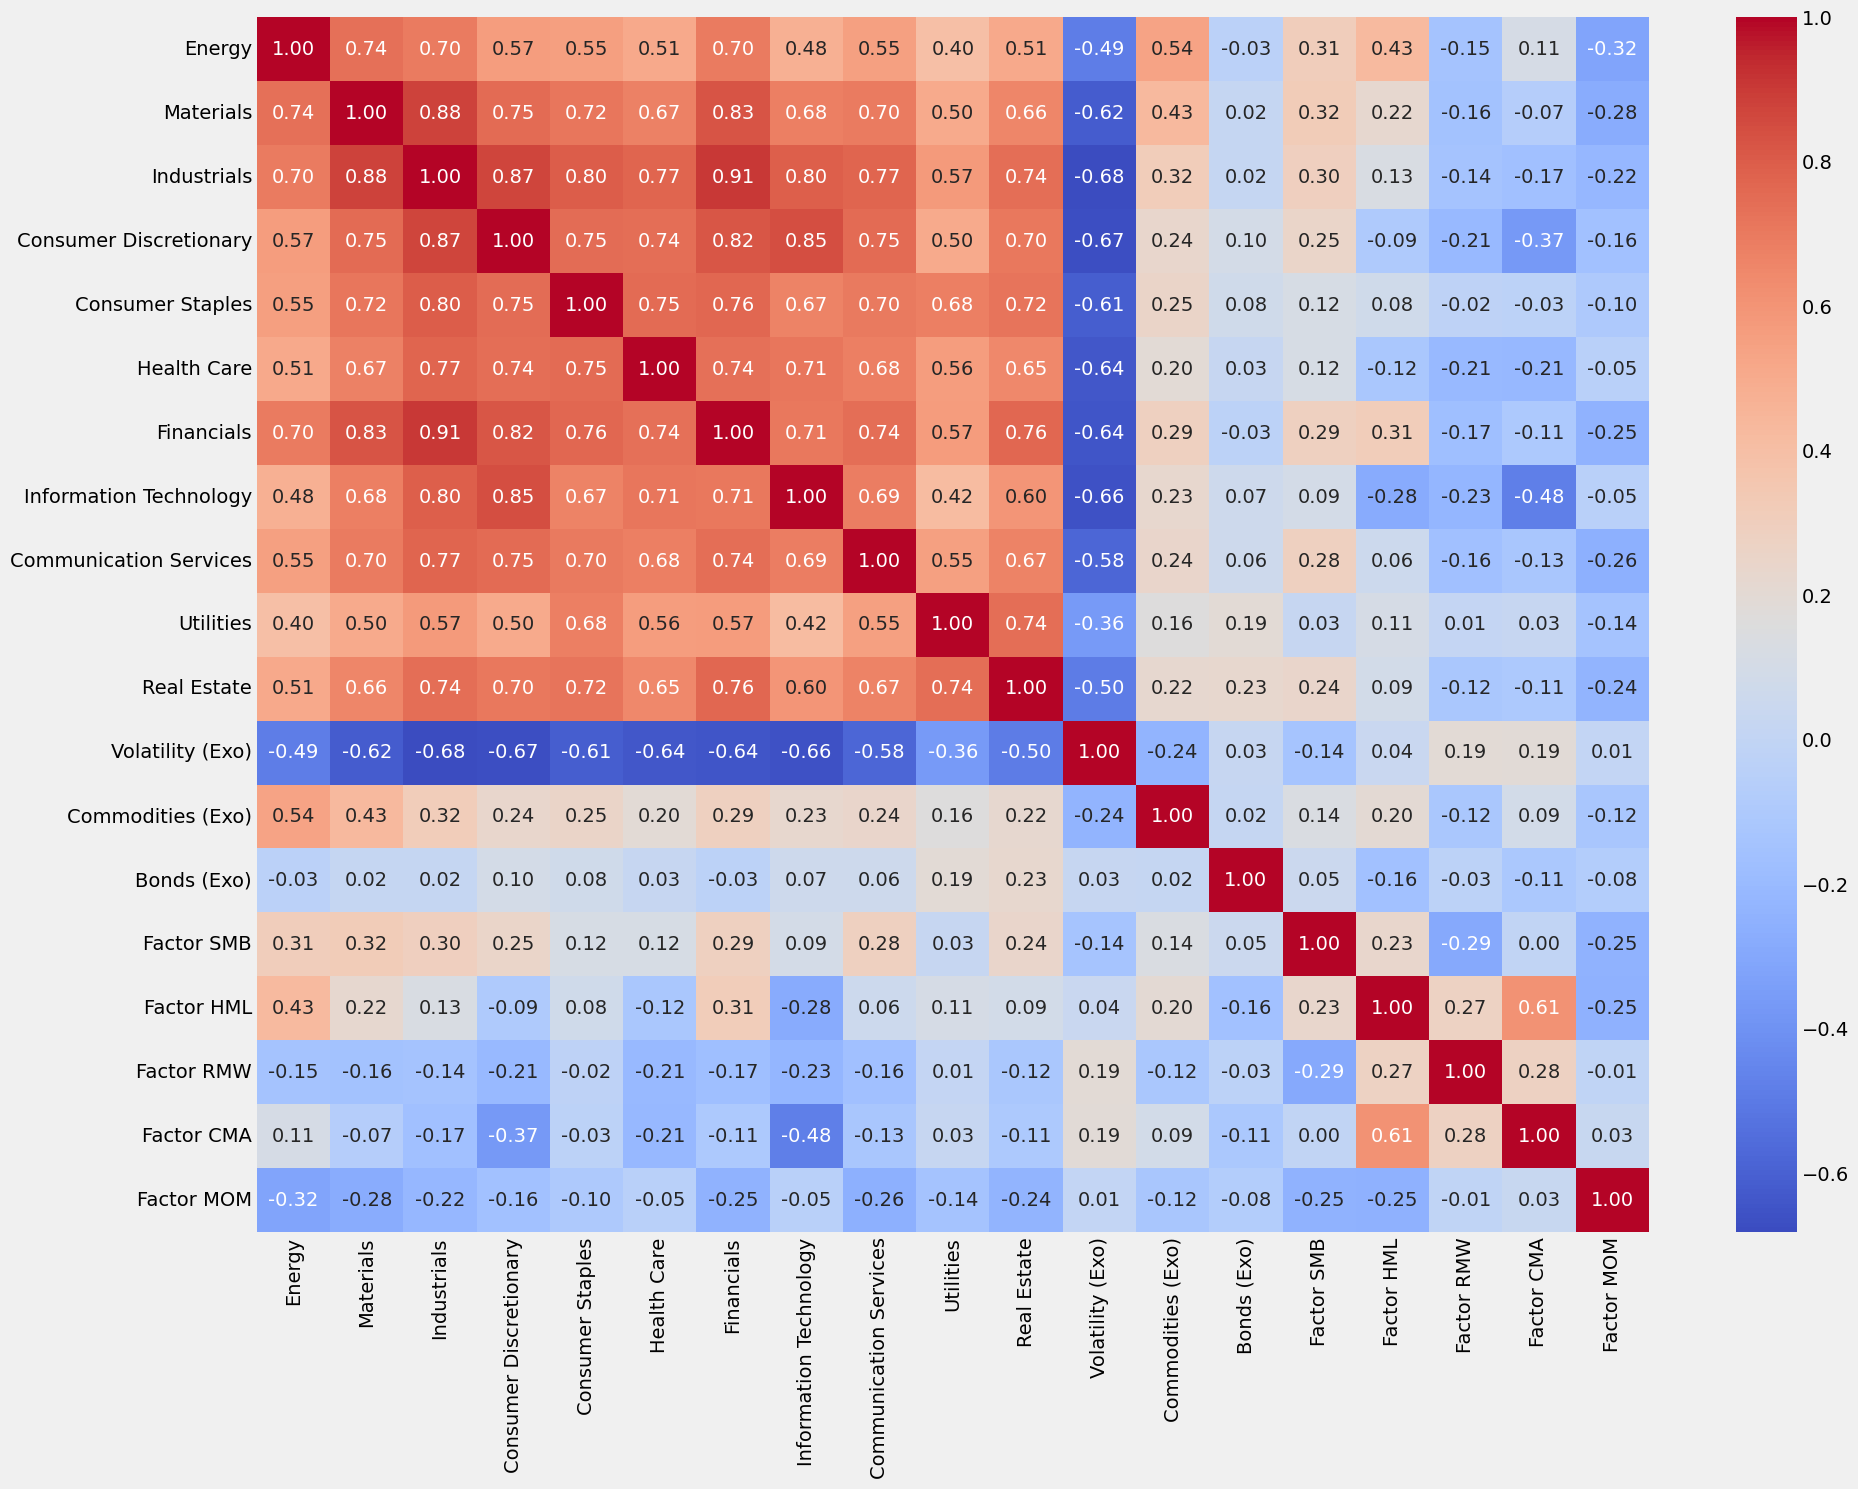

In [22]:
print('Fig. 2 Correlation Matrix of Portfolio Factors')

correlation_matrix = simple_returns.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

There are a couple of interesting insights we can draw from the correlation matrix about our prospective matrix. Firstly, we can see that nine out of eleven S&P 500 GICs sectors have very strong correlation with each other, indiciating the degree of interconnectedness across sectors in the S&P 500 and how periods of expansion and contraction propogate quickly across the US economy. The two factors that buck this trend so to speak are naturally the Energy Sector and less intuitively the Communication Services.

Our exogenous factors are performing exactly as we would expect them to behave. 
The VIX has a very strong negative correlation with the S&P 500 sectors, which intuitively makes sense as periods of intense volatility are most commonly associated with negative downturns on major indicies. Similarly we see only minor correlation between BCOM and the majority of our S&P 500 sectors with the exception of the Energy and Materials sectors which are heavily dependent on commodity prices. The bond index has very low correlation with all of the factors on a negative and positive basis, the only real exception is the Real Estate sector which is probably due to both factors being exposed to interest rate policy. 

Our 'investable' factors derived by Fama-French have almost no correlation with our other factors outside of their subset. 
Our 'investable' factors derived by Fama-French alongside our custom momentum factor have fairly low correlation with our other factors outside of their subset. Both HML & CMA experience some moderate correlation with each other, potentially due to the overlap in portfolios, but outside of that there is only slight correlation amongst the factors. In particuarly our custom MOM factor provides a very interest diversification effect as it has zero to low negative correlation with all other factors. 

In terms of our portfolio construction we would expect our S&P 500 sector factors to generally mimic the performance of the index, and a small allocation to our exogenous and Fama-French factors should provide some diversification during periods of volatility or counter-cyclical moves. 

#### 1.3 Rolling Alpha & Beta of Portfolio Factors vs S&P 500 Benchmark

TODO:

The Capital Asset Pricing Model derived by William Sharpe provides us with a framework to determine the expected return on an asset given its risk relative to the market. 

$$
E [ R_i] = r_f + (r_m - r_f) \beta_i
$$

The formula assumes that investors must be compensated for the 


Fig. 3 Correlation Beta of Portfolio Factors vs S&P 500


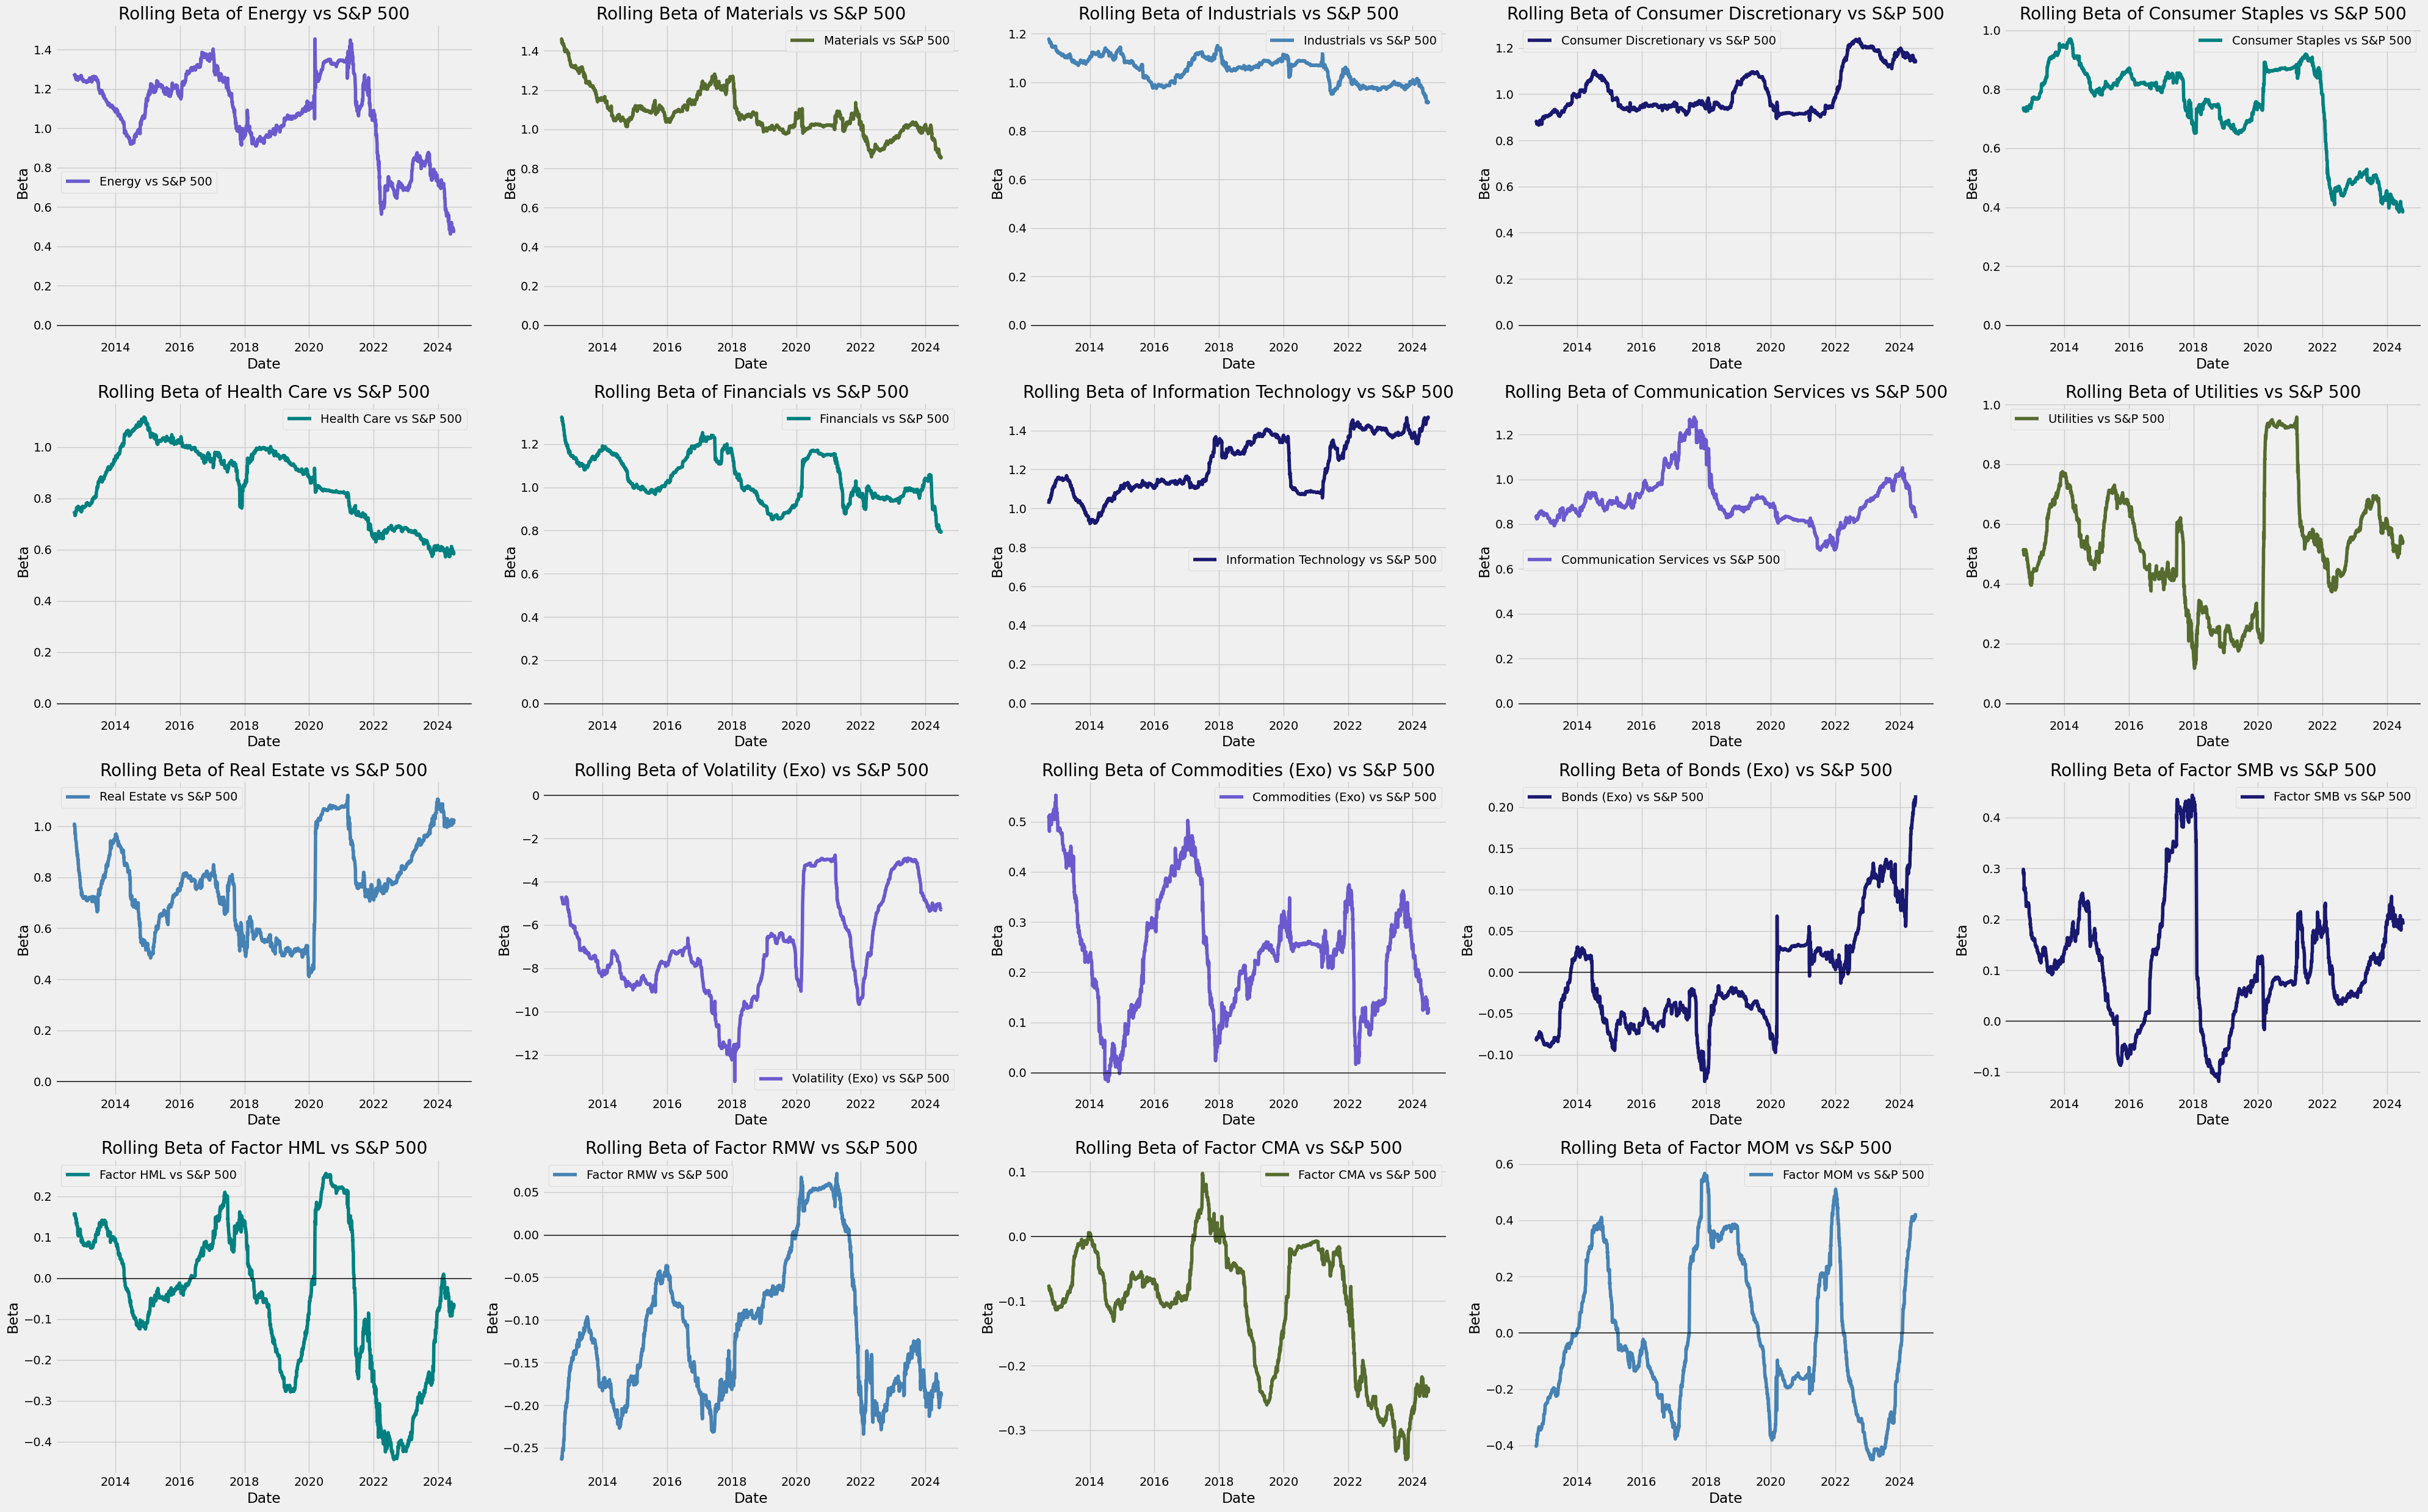

In [23]:
print('Fig. 3 Rolling Beta of Portfolio Factors vs S&P 500')

# grid layout
nrows = 4
ncols = 5

# subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(40, 25))
axes = axes.flatten()

# colour palette
colours = ['#6a5acd', '#008080', '#4682b4', '#556b2f', '#191970']
colours *= (len(log_returns.columns) // len(colours)) + 1
random.shuffle(colours)

for i, column in enumerate(log_returns.columns):
    rolling_beta = calculate_rolling_beta(log_returns[column], benchmark_spx_500.squeeze(), window)
    axes[i].plot(rolling_beta.index, rolling_beta, label=f'{column} vs S&P 500', color=colours[i % len(colours)])
    axes[i].axhline(0, color='black', linewidth=1)
    axes[i].set_title(f'Rolling Beta of {column} vs S&P 500')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Beta')
    axes[i].legend()
    axes[i].grid(True)

# Hide the last empty subplot if necessary
if len(log_returns.columns) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

We can now individually compute a rolling beta calculation for each portfolio factor versus our benchmark index. Beta is a measure of the portfolio factor's sensitivty to the benchmark movements. It indicates how much a factor is expected to change in response to a 1% change in the benchmark. Beta value of 1 indicates the factor moves in line with the market, while any values above 1 indicate the factor will in the amplied direction of the market. Positive values indicate a postitive movement alongside the benchmark movement, while negative value indicate the factor will move inversely to market moves but the strength is preserved. There are a couple of interesting themes to highlight from the graphs. 

All of our s&P 500 factors exhibit consistently high degrees of positive Beta to the overall benchmark. The more growth orientated sectors such as Information Technology, Financials and Consumer Discretionary have very high and increasing levels of Beta, while the more defensive sectors such as Utilities, Consumer Staples, & Energy have lower average Beta and in the most recent years have shown downward trending Beta due to less market sensitvity. However, even the less sensitive factors like Real Estate and Utilities still exhibit around 0.6 Beta with our benchmark index. 

In contrast our exogenous factors exhibit far less Beta wih out benchmark. Commodities exhibits the highest Beta but it tends to cluster around periods of extreme volatility where higher commodity prices can feed into other sectors of the benchmark and cause market disruption. Bonds displays almost no Beta with our benchmark index until recent years where higher interests have had caused changes in other sectors like Real Estate. Finally, our VIX index has highly negative and extreme Beta values indicating a very strong inverse relationship with out benchmark. All three of our exogenous factors could offer varying levels of hedging ability to our traditional sector portfolio. 

Our Fama-French factor also produce a fairly low Beta value for our benchmark. In particular HML, RMW & CMA have experienced declining Betas towards teh S&P potentially reflecting the fact the portfolios are comprised of less popular factors for this time period of investing. SMB has the highest Beta values for the factors and has a moderate correlation to periods of cyclical expansion in the benchmark. Finally, our custom Momentum factor generally has negative Beta with the benchmark but during periods of market stress becomes very strongly correlated with the index indicating it could act as a poor hedge factor as it loses it's uncorrelation when we need it compared to our VIX factor.

Fig. 4 Rolling Alpha of Portfolio Factors vs S&P 500


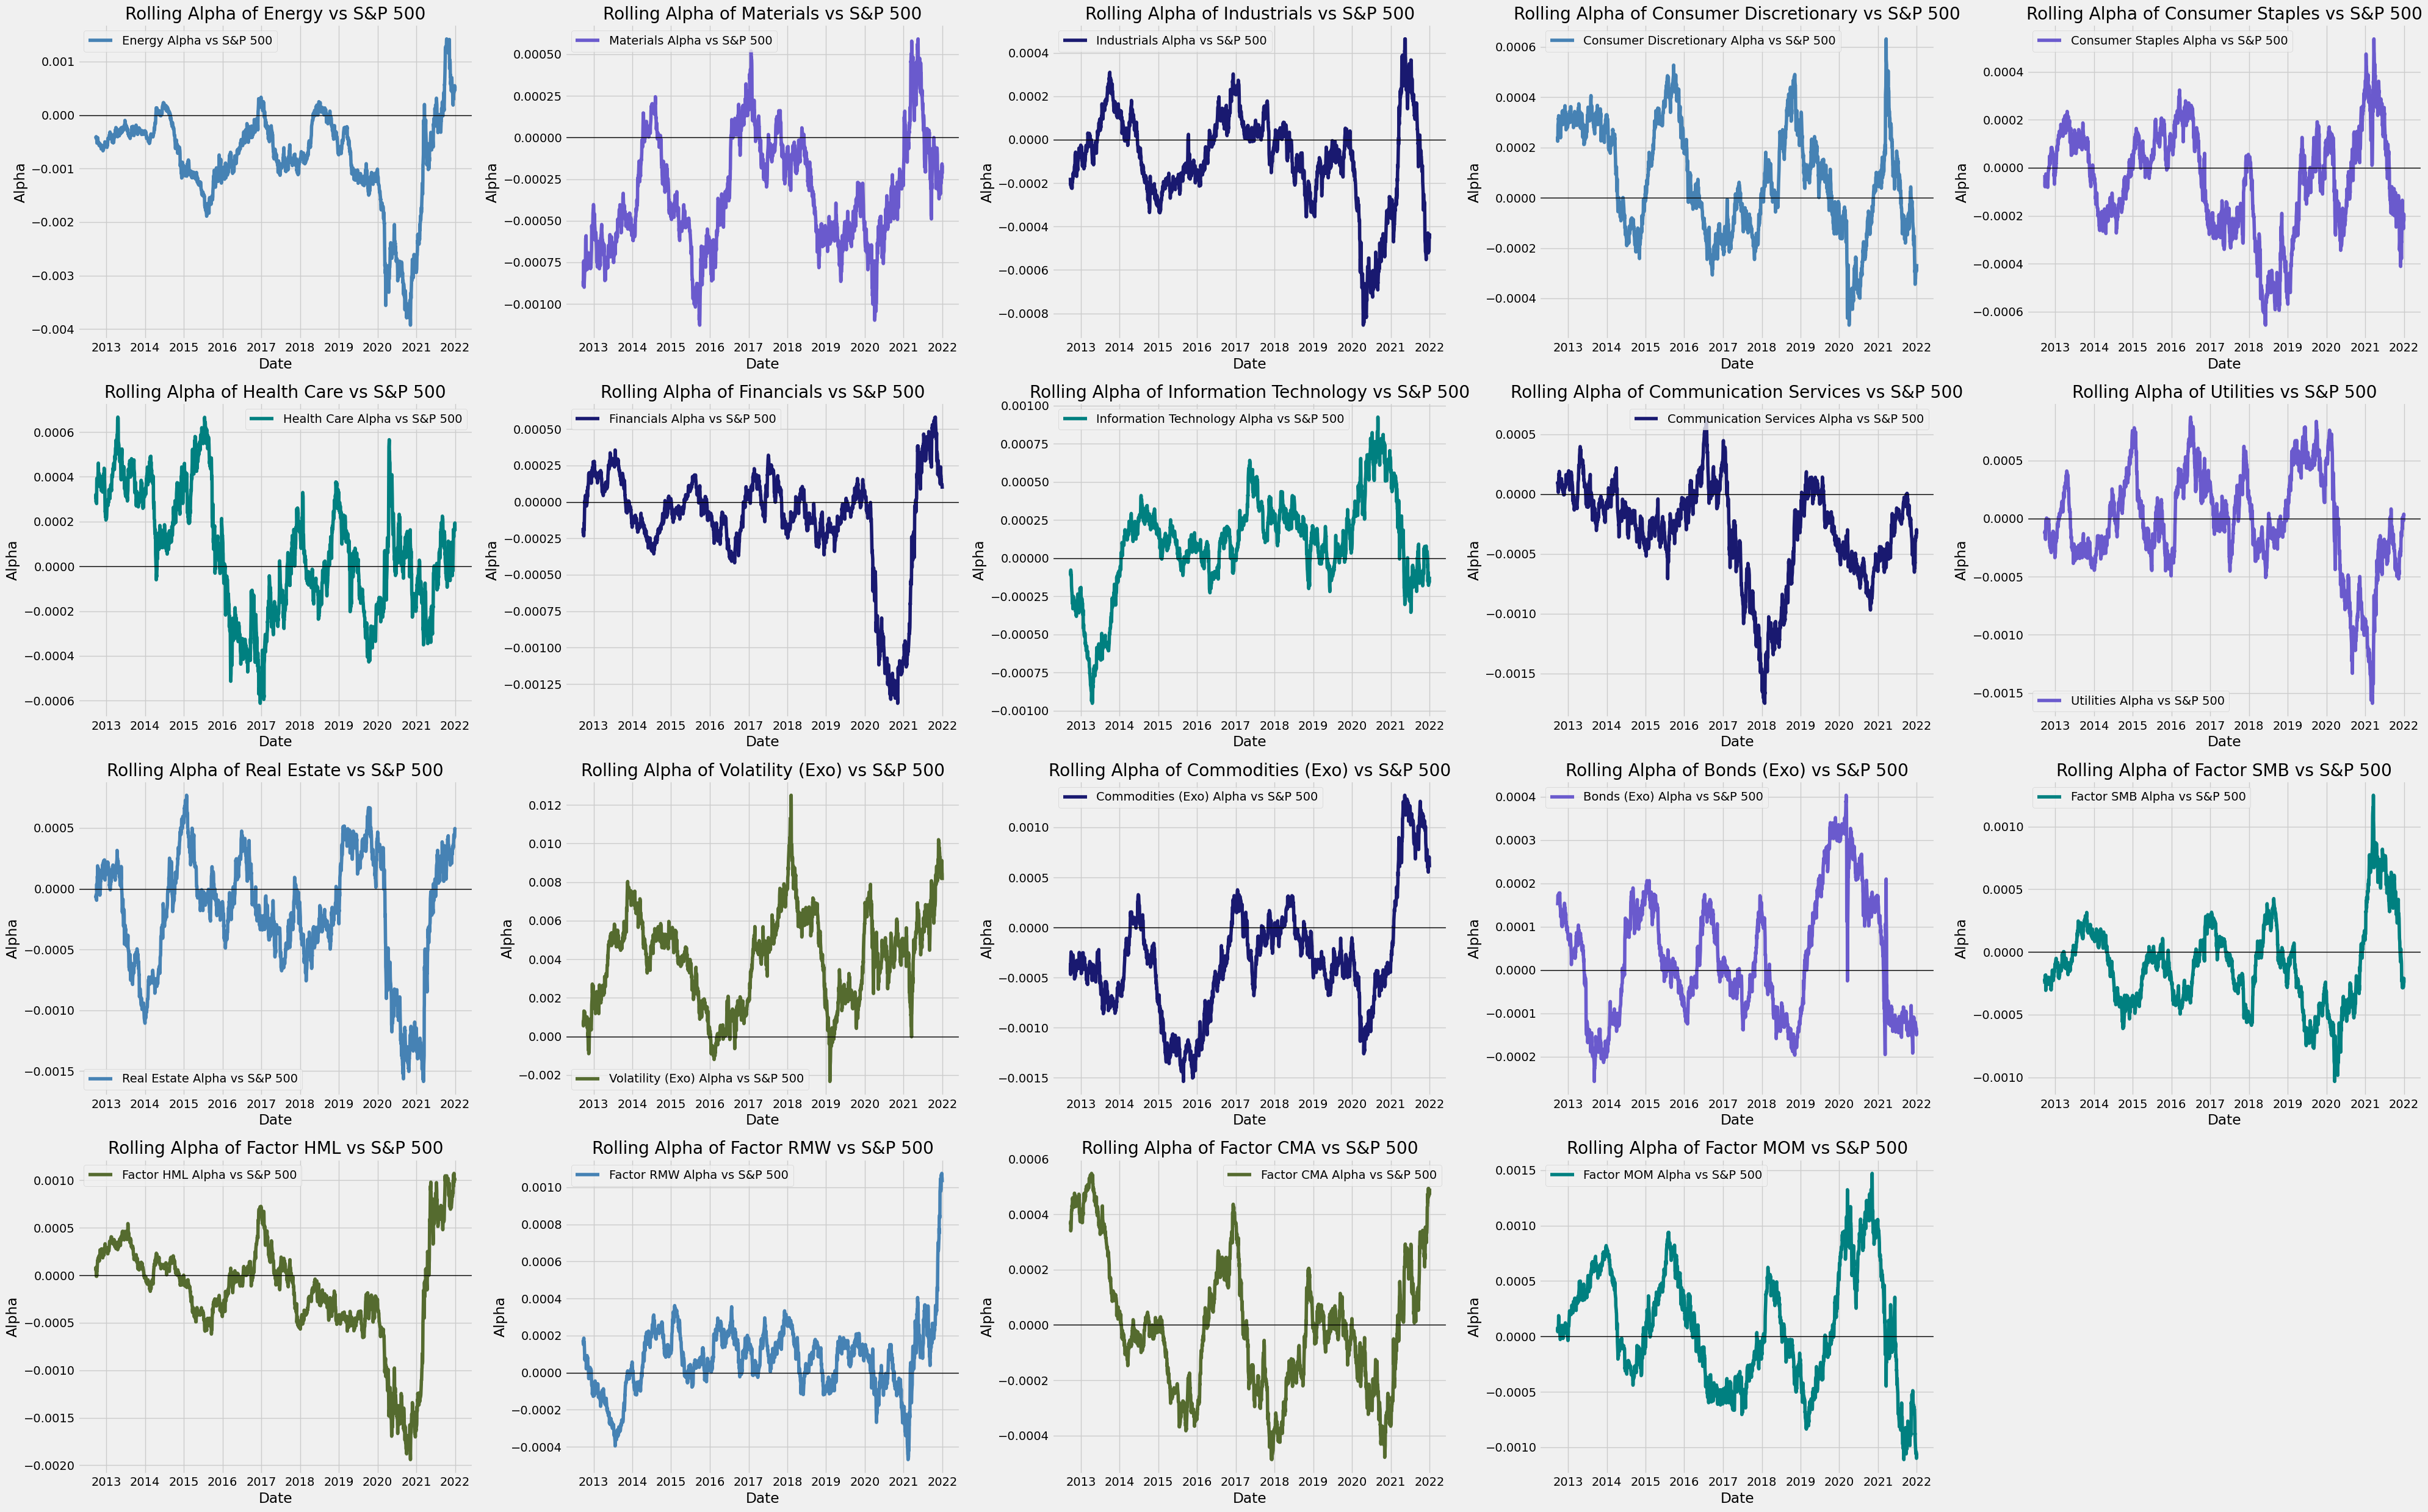

In [24]:
print('Fig. 4 Rolling Alpha of Portfolio Factors vs S&P 500')

# Grid layout for subplots
nrows = 4
ncols = 5

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(40, 25))
axes = axes.flatten()

# Colour palette
colours = ['#6a5acd', '#008080', '#4682b4', '#556b2f', '#191970']
colours *= (len(log_returns_back_testing.columns) // len(colours)) + 1
random.shuffle(colours)

# Loop over each factor to compute and plot rolling alpha
for i, column in enumerate(log_returns_back_testing.columns):
    rolling_alpha = calculate_rolling_alpha(log_returns_back_testing[column], benchmark_spx_500_back_testing.squeeze(), window)
    axes[i].plot(rolling_alpha.index, rolling_alpha, label=f'{column} Alpha vs S&P 500', color=colours[i % len(colours)])
    axes[i].axhline(0, color='black', linewidth=1)
    axes[i].set_title(f'Rolling Alpha of {column} vs S&P 500')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Alpha')
    axes[i].legend()
    axes[i].grid(True)

# Hide the last empty subplot if necessary
if len(log_returns_back_testing.columns) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

We calculate our rolling alpha as the excess return on our portfolio factors after subtracting the benchmark return and an error term. We broadly see similar themes to our Beta graphs. The majority of the returns for our sector factors comes from the benchmark return. We see quite consistent and high alpha generated by our exogenous factors VIX and Bonds which underlines their strength as hedges in our sector portfolio. Commodities also show a very high peaks in particular periods of market stress giving us another source of outperformance when allocated to correctly. Our Fama-French factors show similar results to commodities they tends generate quite low alpha outside of particular market conditions. 

#### 1.3 Portfolio Factors PnL vs S&P 500 Benchmark

Fig. 5 Cumulative Return of Portfolio Factors vs S&P 500


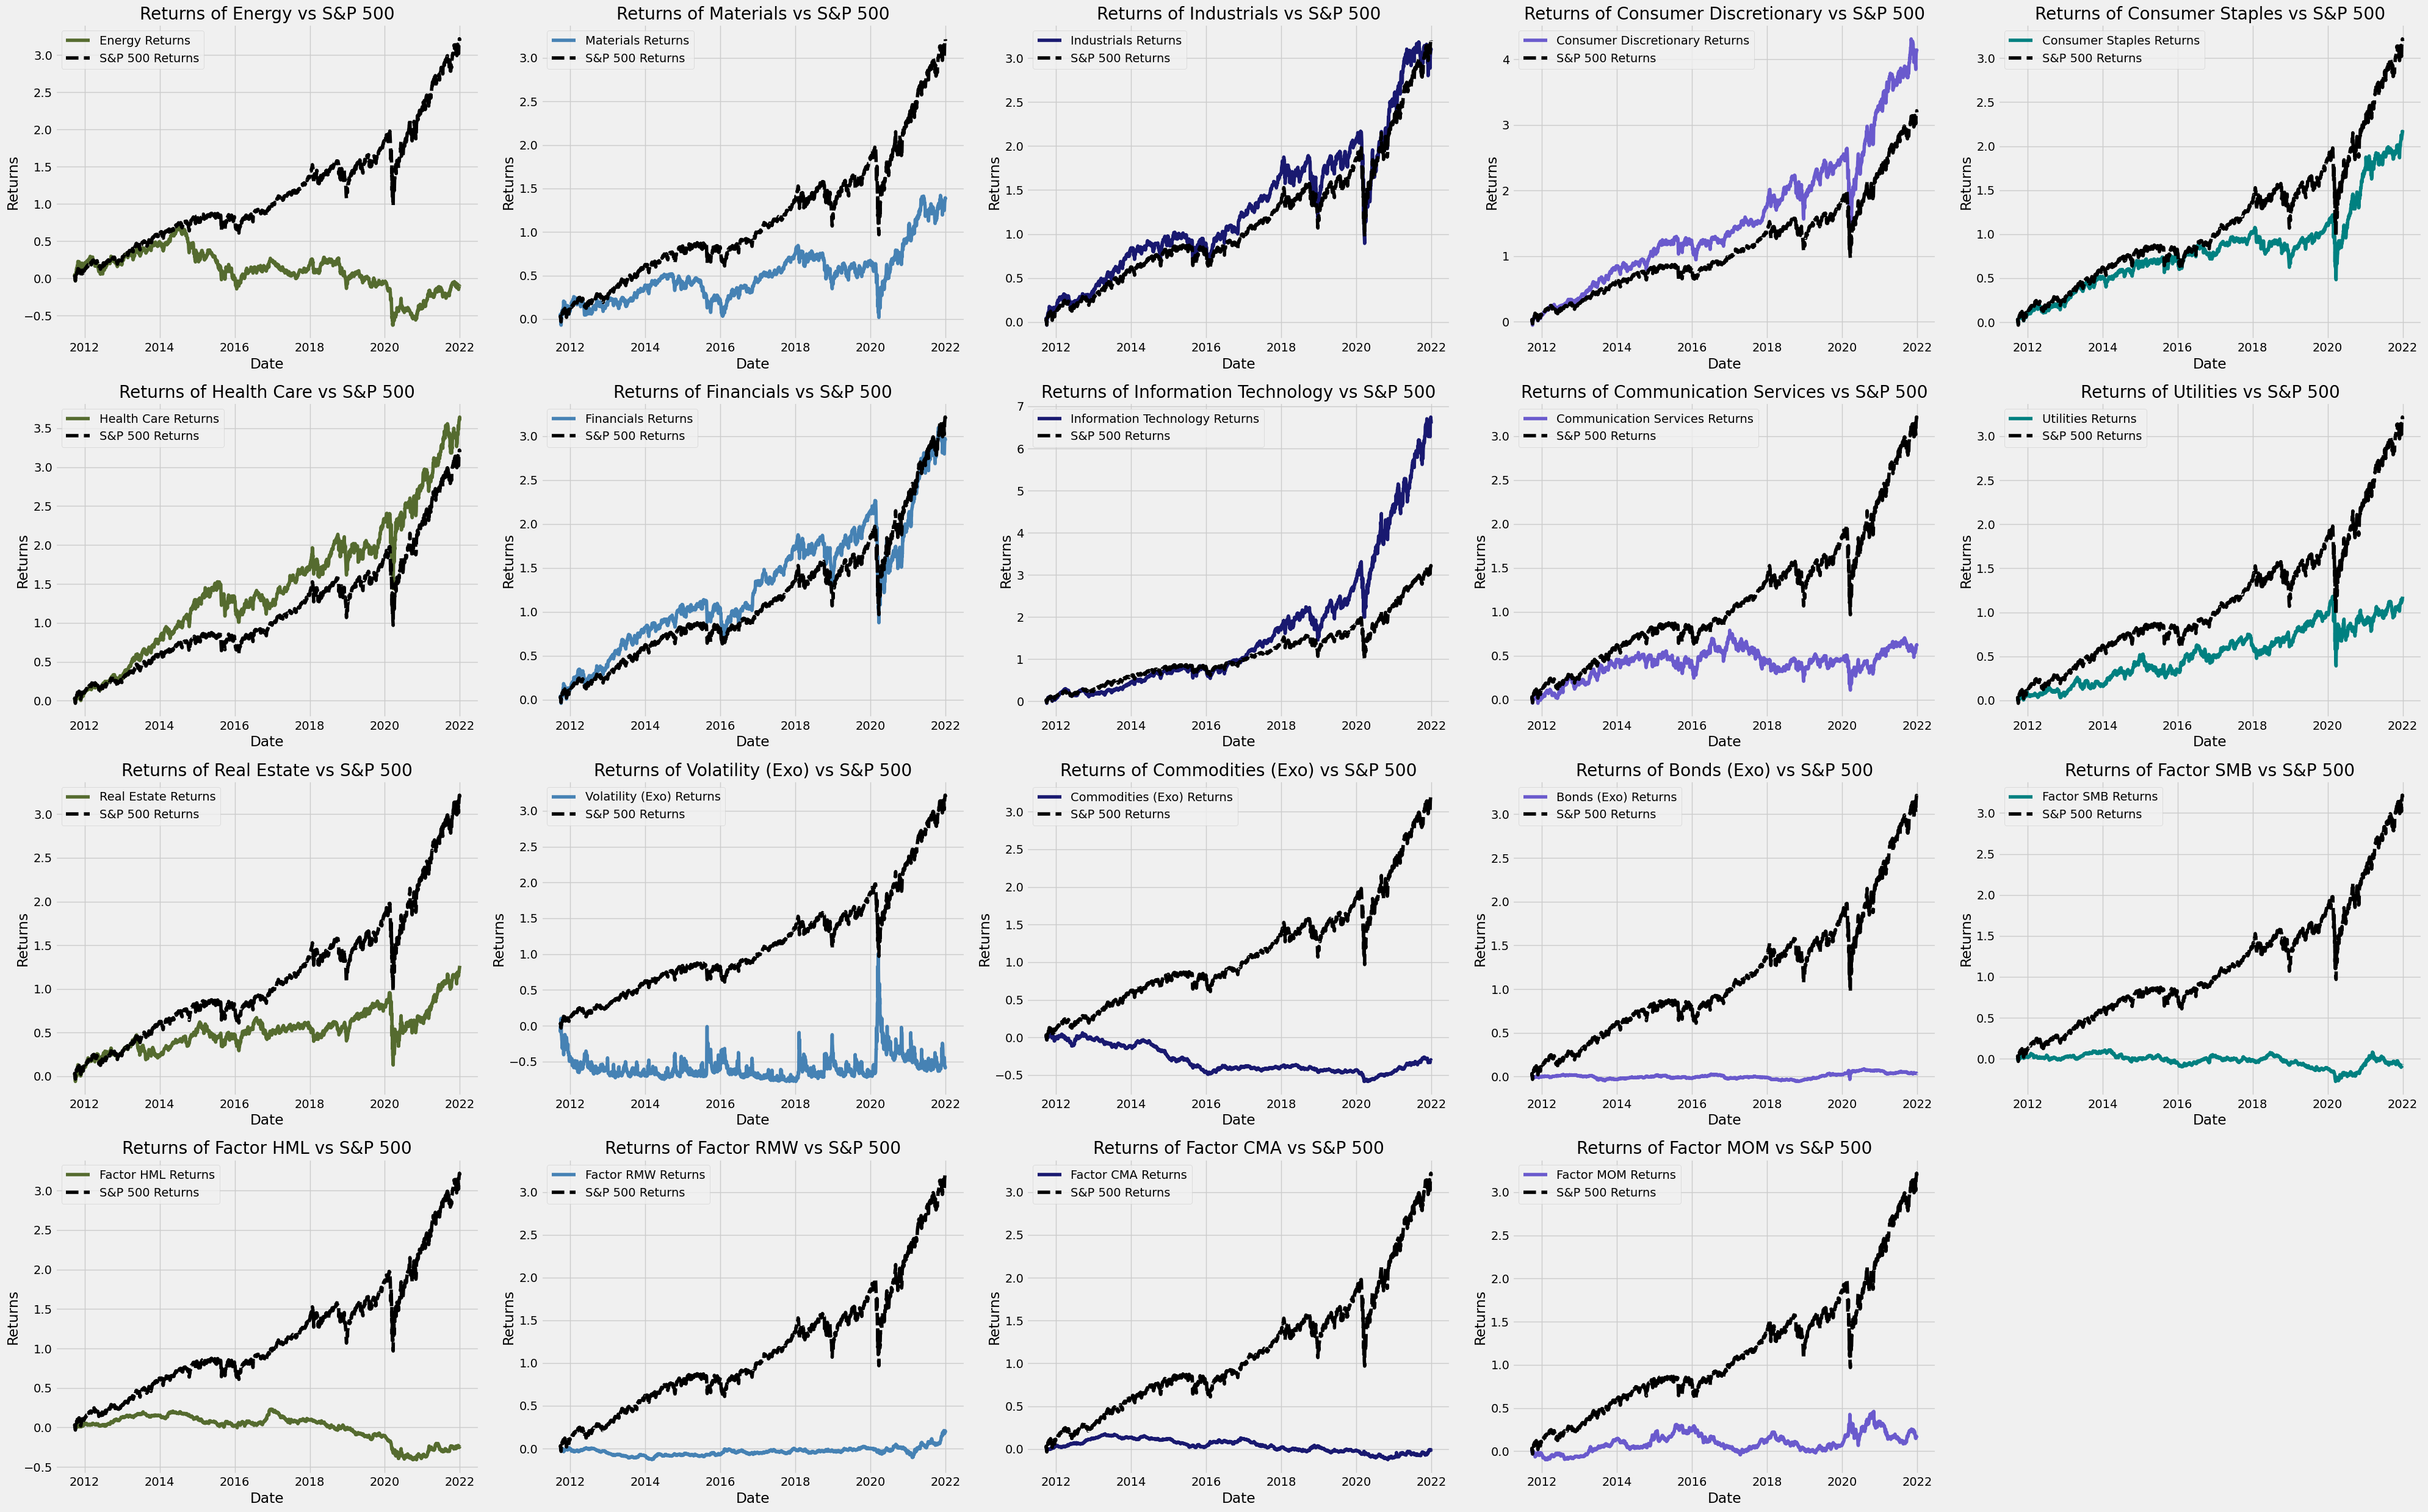

In [25]:
print('Fig. 5 Cumulative Return of Portfolio Factors vs S&P 500')

# Number of rows and columns for the subplot grid
nrows = 4
ncols = 5

# Subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(40, 25))
axes = axes.flatten()

# Colour palette
colours = ['#6a5acd', '#008080', '#4682b4', '#556b2f', '#191970']
random.shuffle(colours)

# Plot each factor's returns vs. the benchmark
for i, column in enumerate(cumulative_returns_back_testing.columns):
    # Plot the factor returns and benchmark returns
    axes[i].plot(cumulative_returns_back_testing.index, cumulative_returns_back_testing[column], label=f'{column} Returns', color=colours[i % len(colours)])
    axes[i].plot(cumulative_benchmark_spx_500_back_testing.index, cumulative_benchmark_spx_500_back_testing, label='S&P 500 Returns', color='black', linestyle='--')
    axes[i].set_title(f'Returns of {column} vs S&P 500')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Returns')
    axes[i].legend()
    axes[i].grid(True)

# Hide any remaining empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

We can now provide the cumulative return for each out portfolio factors. We will start with our sector returns. We can see a very clear bias between cyclical and counter cyclical sectors. Energy, Materials, Consumer Staples, Utilities, Communication Services should consistent underperformance for the benchmark while the cyclical-higher growth sectors Information Technology, Consumer Discretionary, Financials show an overperformance for the benchmark. This is unsurprising as the dataset covers a particularly strong economic growth period since 2012 with accomodative monetary policy. However, it does illustrate that current portfolio construction methods are likely to overweight continuing trends rather than accounting for any reversals in economic conditions which could cause changes in sector performance. 

Our exogenous factors and Fama-French factors also demonstrate the low correlation to our benchmark index does not necessarily confer advantages if the cumulative performance is significantly lower. Allocating to our commodity exogenous factor would actually generate negative returns over this period, and Bond would generate a fraction of the returns of our benchmark. Once again the most interesting exogenous factor is our VIX index, it does not produce consistent cumulative returns like the benchmark but it provides significant short term hedging capabilities which can help mitigate the worst of the drawdowns. Our selection of Fama-French factors similarly produced uncorrelated, but poor returns as a contribution to our portfolio. Our momentum factors performns much better than the derived Fama-French factors as while the overall performance is still lower than our benchmark it does over a more attractive return profile and provides support during some downturns. 

#### 1.4 What is the Black-Litterman Portfolio

The initial formulation of the Black-Litterman model for Portfolio construction was described in the 1992 paper. The paper described an intuitive solution by combining the mean-variance opitimisation framework of Markowitz and the capital asset pricing model (CAPM) of Sharpe and Lintner. The issue with the CAPM model and minimum-variance portfolio decribed by Markowitz is that small tweaks in the values could lead to significant rebalancing of the portfolio. The Markowitz framework effectively takes the risk-free return as the alternative benchmark. The Black-Litterman model on the otherhand uses equilibrium risk premiums to provide a neutral reference point for expected returns, generating a market-capitalisation-weighted-portfolio and then incorporating subjective views that tilts in the direction of assets favored by the investor to enable the generation of alpha. The Black-Litterman models assumes does not assume the model is always at CAPM equilibrium, but any shift away from this equilibrium will experience pressure from the market to revert. Furthermore, the model allows the investor to have as many, or as few, views as they wish on either an absolute or relative basis. 

We will undertake the following steps in the next few sections to construct our portfolio according to the Black-Litterman framework. Firstly, we need to assign our portfolio weights based upon the market capitalisation of our benchmark portfolio. As previously outlined we will assign 92% of our portfolio to the S&P 500 sectors that we have proxied via iShares ETFs and will according allocate based on their weight in the S&P 500 in 2022. The remaining 8% of the portfolio will be equally split across our three exogenous factors, four Fama-French factors and custom momentum factor. Based on these weights we will derive the implied market returns for each of our factors. Due to this method of deriving the market implied returns the frame work does not recommend deviating from the market returns until you formulate views about the factor that cause them to deviate on either an absolute or relative basis from the implied returns. Once we have formulated our views on the market then we will combine our market implied returns and views via Bayes Theorem to construct a posterior returns distribution. 

We will then use our posterior returns distribution to calculate our views adjusted optimal weights for our portfolio. Finally, once we have completed this optimisation we will compare how our new portfolio performs vs the benchmark S&P from 2022 to 2024. 

While the Markowitz mean-variance optimisation is designed to use discrete returns, the Black-Litterman model is based on log return which we will use here. 

$$

R_{i} = log(1 + \frac{P_{i+1}}{P_i})

$$

Fig. 6 Default Weights from S&P 500 per GICs Sector (2022)

| Sector                  | Weights  |
| :---------------------: | :---:    |
| Information Technology  | 28.10%   |
| Financials              | 11.50%   |
| Health Care             | 13.30%   |
| Consumer Discretionary  | 11.8%    |
| Communication           | 9.60%    |
| Industrials             | 8.00%    |
| Consumer Staples        | 6.20%    |
| Energy                  | 3.70%    |
| Utilities               | 2.60%    |
| Real Estate             | 2.60%    |
| Materials               | 2.60%    |

#### Bibliography


Sharpe, W. - 1964. “Capital Asset Prices: A Theory of Market Equilibrium under Conditions of Risk.” Journal of Finance. 19:3, pp. 425–42
